In [ ]:
%load_ext autoreload
%autoreload 2


import pandas as pd
import numpy as np
import json
import pickle
from pathlib import Path
from datetime import datetime
import warnings
import sys
warnings.filterwarnings('ignore')

In [2]:
# Configuration
BASE_DIR = Path().resolve().parent.parent
sys.path.append(str(BASE_DIR / "src"))

# Répertoires
DATA_DIR = BASE_DIR / "data"

SRC_PATH = BASE_DIR / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))
    
# Définition des chemins en fonction de ta structure actuelle

PROCESSED_DIR = DATA_DIR / "processed"
EXPORTS_DIR = DATA_DIR / "exports"
VISUALS_DIR = PROCESSED_DIR / "visuals"
RESULTS_DIR = DATA_DIR / "results"
RESULTS_DIR.mkdir(exist_ok=True)
OUTPUTS_DIR = BASE_DIR / "outputs"
OUTPUTS_DIR.mkdir(exist_ok=True)



In [3]:
# IMPORTS OPTIMISES - Version fusionnee avec performance amelioree
from scripts.summarizer_engine import (
    summarize_text_with_ensemble,    # API compatible optimisee
    batch_summarize_optimized,       # Nouvelle API batch
    OptimizedModelManager,           # Gestionnaire de modeles
    get_or_create_model_manager      # Fonction utilitaire
)
from evaluation.comprehensive_evaluator import ComprehensiveEvaluator
from evaluation.human_evaluation import HumanEvaluationInterface
import pandas as pd
import json

pd.set_option('display.max_colwidth', 300)

print("Imports optimises charges:")
print("  - summarize_text_with_ensemble (version fusionnee optimisee)")
print("  - batch_summarize_optimized (nouveau)")
print("  - OptimizedModelManager (nouveau)")
print("  - get_or_create_model_manager (nouveau)")
print("Toutes les fonctions utilisent maintenant la version optimisee par defaut")

Imports optimises charges:
  - summarize_text_with_ensemble (version fusionnee optimisee)
  - batch_summarize_optimized (nouveau)
  - OptimizedModelManager (nouveau)
  - get_or_create_model_manager (nouveau)
Toutes les fonctions utilisent maintenant la version optimisee par defaut


In [4]:
# Choisir ton fichier de calibration ou corpus 
CORPUS_PATH = PROCESSED_DIR / "calibration_corpus_300.json"

with open(CORPUS_PATH, "r", encoding="utf-8") as f:
    corpus_data = json.load(f)





In [5]:
corpus_data[0]



{'id': 491,
 'title': 'Comment le Wi-Fi peut permettre de vous pister, même à travers les murs',
 'text_cleaned': 'Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des chercheurs italiens ont en effet mis au point un système de surveillance qui analyse la manière dont chaque corps humain perturbe les signaux Wi-Fi. Des chercheurs italiens ont découvert qu’il était possible de pister un individu en se servant du Wi-Fi. Développé par des scientifiques de l’Université La Sapienza de Rome, l’outil, appelé « WhoFi », est capable de reconnaître une personne rien qu’en analysant la manière dont son corps interagit avec les ondes Wi-Fi. Une empreinte invisible En effet, le corps d’une personne interfère de façon unique avec le Wi-Fi. Les interférences dépendent de la forme du corps humain en question. « L’idée centrale est que, lorsqu’un signal Wi-Fi se propage dans un environnement, sa forme d’onde est modifiée par la présence et les caractéristiques

In [6]:
from datetime import datetime

def normalize_and_fill_dates(docs):
    for doc in docs:
        raw_date = doc.get("published")
        final_date = None
        used_fallback = False
        
        # Conversion ISO ou fallback
        if isinstance(raw_date, str):
            try:
                final_date = datetime.fromisoformat(raw_date.replace("Z", ""))
            except Exception:
                used_fallback = True
        elif isinstance(raw_date, datetime):
            final_date = raw_date
        
        
        if not final_date:
            if "created_at" in doc and isinstance(doc["created_at"], datetime):
                final_date = doc["created_at"]
            else:
                final_date = datetime.utcnow()
            

        # Normalisation du champ published
        doc["published"] = final_date
        

        # Gestion du champ 'dates'
        if "entities_advanced" in doc and isinstance(doc["entities_advanced"], dict):
            # si dates est vide, on injecte la date publiée
            if not doc["entities_advanced"].get("dates"):
                doc["entities_advanced"]["dates"] = [final_date.strftime("%Y-%m-%d")]
                
            
        else:
            # s'assurer que le champ existe
            doc["entities_advanced"] = {"dates": [final_date.strftime("%Y-%m-%d")]}
            
    
    return docs


In [7]:

# Application sur ton corpus
corpus_data = normalize_and_fill_dates(corpus_data)



In [8]:
import spacy
from datetime import datetime

# Charger un modèle spaCy multilingue ou spécifique au français
nlp = spacy.load("fr_core_news_md") # "fr_core_news_sm" plus leger mais moins précis

def ensure_entities(doc):
    """
    Vérifie et complète les entités d'un document avec fallback sur text_cleaned.
    """
    expected_keys = ["persons", "organizations", "locations", "dates", "money", "misc"]
    
    if "entities_advanced" not in doc or not isinstance(doc["entities_advanced"], dict):
        doc["entities_advanced"] = {k: [] for k in expected_keys}
    
    text = doc.get("text_cleaned") or doc.get("text", "")
    if not text:
        return doc  # rien à analyser
    
    doc_spacy = nlp(text)
    
    # Mapping spaCy → nos catégories
    spacy_to_custom = {
        "PER": "persons",
        "ORG": "organizations",
        "LOC": "locations",
        "GPE": "locations",
        "DATE": "dates",
        "TIME": "dates",
        "MONEY": "money"
    }
    
    # Remplir seulement les champs vides
    for ent in doc_spacy.ents:
        target = spacy_to_custom.get(ent.label_)
        if target and not doc["entities_advanced"].get(target):
            doc["entities_advanced"][target] = [ent.text]
    
    # Vérifie si dates encore vides → utiliser fallback sur published
    if not doc["entities_advanced"].get("dates"):
        published = doc.get("published")
        if isinstance(published, datetime):
            doc["entities_advanced"]["dates"] = [published.strftime("%Y-%m-%d")]
            
    return doc

def enrich_entities_corpus(corpus):
    """
    Applique ensure_entities à un corpus (list[dict]) ou un seul article (dict).
    """
    if isinstance(corpus, dict):  
        return [ensure_entities(corpus)]  
    
    if isinstance(corpus, list):
        return [ensure_entities(doc) for doc in corpus]
    
    raise TypeError("Le corpus doit être un dict ou une liste de dicts")



In [9]:
# Application sur ton corpus
corpus_data = enrich_entities_corpus(corpus_data)




In [10]:

corpus_data[0]


{'id': 491,
 'title': 'Comment le Wi-Fi peut permettre de vous pister, même à travers les murs',
 'text_cleaned': 'Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des chercheurs italiens ont en effet mis au point un système de surveillance qui analyse la manière dont chaque corps humain perturbe les signaux Wi-Fi. Des chercheurs italiens ont découvert qu’il était possible de pister un individu en se servant du Wi-Fi. Développé par des scientifiques de l’Université La Sapienza de Rome, l’outil, appelé « WhoFi », est capable de reconnaître une personne rien qu’en analysant la manière dont son corps interagit avec les ondes Wi-Fi. Une empreinte invisible En effet, le corps d’une personne interfère de façon unique avec le Wi-Fi. Les interférences dépendent de la forme du corps humain en question. « L’idée centrale est que, lorsqu’un signal Wi-Fi se propage dans un environnement, sa forme d’onde est modifiée par la présence et les caractéristiques

In [11]:
article_example = {
    "id": 999,
    "title": "Emmanuel Macron discute d'économie avec Ursula von der Leyen à Bruxelles le 25 juillet 2025",
    "text_cleaned": "Le président français Emmanuel Macron a rencontré la présidente de la Commission européenne, Ursula von der Leyen, à Bruxelles le 25 juillet 2025. "
                    "Ils ont annoncé un plan de relance économique de 500 millions d’euros pour l’Europe.",
    "source": "https://www.france24.com/fr/rss",
    "published": datetime(2025, 7, 25, 15, 0, 0),
    "language": "fr",
    "entities_advanced": {  
        "persons": [],
        "organizations": [],
        "locations": [],
        "dates": [],
        "money": [],
        "misc": []
    }
}
import pprint
corpus_article_example = enrich_entities_corpus(article_example)  
pprint.pprint(corpus_article_example[0])



{'entities_advanced': {'dates': ['2025-07-25'],
                       'locations': ['Bruxelles'],
                       'misc': [],
                       'money': [],
                       'organizations': ['Commission européenne'],
                       'persons': ['Emmanuel Macron']},
 'id': 999,
 'language': 'fr',
 'published': datetime.datetime(2025, 7, 25, 15, 0),
 'source': 'https://www.france24.com/fr/rss',
 'text_cleaned': 'Le président français Emmanuel Macron a rencontré la '
                 'présidente de la Commission européenne, Ursula von der '
                 'Leyen, à Bruxelles le 25 juillet 2025. Ils ont annoncé un '
                 'plan de relance économique de 500 millions d’euros pour '
                 'l’Europe.',
 'title': "Emmanuel Macron discute d'économie avec Ursula von der Leyen à "
          'Bruxelles le 25 juillet 2025'}


<!--
 Copyright 2025 beedi.goua_square-ma
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



In [12]:


import sys
from pathlib import Path
import re

# Ajouter utils au path
utils_path = Path("../..").resolve() / "src" / "utils"
if str(utils_path) not in sys.path:
    sys.path.insert(0, str(utils_path))

from text_cleaner import clean_text_for_summary

def get_text(doc, prefer_cleaned=True, min_length=50, clean_metadata=True):
    """
    Recupere le texte principal d'un document en gerant les cas particuliers,
    avec fallback automatique et nettoyage optionnel des metadonnees.
    
    Args:
        doc (dict): Document contenant potentiellement les champs 'text_cleaned' ou 'text'.
        prefer_cleaned (bool): Si True, privilegie 'text_cleaned' quand il existe.
        min_length (int): Longueur minimale du texte pour le considerer valide.
        clean_metadata (bool): Si True, nettoie les metadonnees parasites.
    
    Returns:
        str: Le texte selectionne ou une chaine vide si rien de valide n'est trouve.
    """
    
    if not isinstance(doc, dict):
        raise TypeError(f"Le document doit etre un dict, recu {type(doc)}")
    
    text = ""
    fallback_used = False

    # 1. Priorite au texte nettoye
    if prefer_cleaned and "text_cleaned" in doc:
        if doc["text_cleaned"] and len(doc["text_cleaned"].strip()) >= min_length:
            text = doc["text_cleaned"].strip()
        else:
            fallback_used = True

    # 2. Fallback sur le texte brut
    if (not text) and "text" in doc:
        if doc["text"] and len(doc["text"].strip()) >= min_length:
            text = doc["text"].strip()
            if fallback_used:
                print(f"Fallback utilise pour ID={doc.get('id', 'inconnu')} (text_cleaned vide ou trop court)")

    # 3. Aucun texte valide
    if not text:
        print(f"Aucun champ texte valide trouve pour ID={doc.get('id', 'inconnu')}")
        return ""

    # 4. NOUVEAU: Nettoyage metadonnees si active
    if clean_metadata and text:
        original_length = len(text)
        cleaned_text = clean_text_for_summary(text, aggressive=False)
        
        if cleaned_text:
            final_length = len(cleaned_text)
            reduction = 100 * (1 - final_length / original_length)
            
            if reduction > 5:  # Plus de 5% de reduction
                print(f"Metadonnees nettoyees pour ID={doc.get('id', 'inconnu')}: "
                      f"{reduction:.1f}% de reduction ({original_length} -> {final_length} caracteres)")
            
            return cleaned_text
        else:
            print(f"Texte rejete apres nettoyage pour ID={doc.get('id', 'inconnu')} (qualite insuffisante)")
            return ""

    return text

# Test du nettoyage sur un echantillon avec metadonnees simulees
def test_cleaning():
    """Test de la fonction de nettoyage"""
    test_doc = {
        "id": "test_001",
        "text_cleaned": """
        Des chercheurs italiens ont developpe un systeme revolutionnaire.
        Cette technologie pourrait changer notre facon de voir la surveillance.
        PHOTO: JAKUB PORZYCKI / NURPHOTO VIA AFP
        Lire plus tard Google Actualites Partager cet article
        Pour ne manquer aucune actualite, suivez-nous sur Twitter.
        """
    }
    
    print("TEST NETTOYAGE METADONNEES:")
    print("Texte original:")
    print(test_doc["text_cleaned"][:200] + "...")
    
    cleaned = get_text(test_doc, clean_metadata=True)
    print(f"\nTexte nettoye:")
    print(cleaned[:200] + "...")
    
    return cleaned

# Executer le test
cleaned_sample = test_cleaning()

TEST NETTOYAGE METADONNEES:
Texte original:

        Des chercheurs italiens ont developpe un systeme revolutionnaire.
        Cette technologie pourrait changer notre facon de voir la surveillance.
        PHOTO: JAKUB PORZYCKI / NURPHOTO VIA ...
Metadonnees nettoyees pour ID=test_001: 54.2% de reduction (323 -> 148 caracteres)

Texte nettoye:
Des chercheurs italiens ont developpe un systeme revolutionnaire. Cette technologie pourrait changer notre facon de voir la surveillance. , Twitter....


In [13]:
# Extraction du texte du premier document
raw_text = get_text(corpus_data[0])

print("Exemple de texte récupéré :")
print(raw_text[:500])


Exemple de texte récupéré :
Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des chercheurs italiens ont en effet mis au point un système de surveillance qui analyse la manière dont chaque corps humain perturbe les signaux Wi-Fi. Des chercheurs italiens ont découvert qu’il était possible de pister un individu en se servant du Wi-Fi. Développé par des scientifiques de l’Université La S, l’outil, é « WhoFi », est cître une personne rien qu’en analysant la manière dont son corps inte


In [14]:

# Extraction de tous les textes valides
texts = [get_text(doc) for doc in corpus_data if get_text(doc)]
print(f"Nombre de textes valides : {len(texts)} / {len(corpus_data)}")


Metadonnees nettoyees pour ID=125: 7.3% de reduction (3795 -> 3518 caracteres)
Metadonnees nettoyees pour ID=125: 7.3% de reduction (3795 -> 3518 caracteres)
Metadonnees nettoyees pour ID=194: 5.2% de reduction (3751 -> 3555 caracteres)
Metadonnees nettoyees pour ID=194: 5.2% de reduction (3751 -> 3555 caracteres)
Metadonnees nettoyees pour ID=72: 6.3% de reduction (3593 -> 3366 caracteres)
Metadonnees nettoyees pour ID=72: 6.3% de reduction (3593 -> 3366 caracteres)
Metadonnees nettoyees pour ID=56: 5.5% de reduction (3389 -> 3202 caracteres)
Metadonnees nettoyees pour ID=56: 5.5% de reduction (3389 -> 3202 caracteres)
Metadonnees nettoyees pour ID=156: 6.5% de reduction (4737 -> 4427 caracteres)
Metadonnees nettoyees pour ID=156: 6.5% de reduction (4737 -> 4427 caracteres)
Metadonnees nettoyees pour ID=505: 6.2% de reduction (4058 -> 3806 caracteres)
Metadonnees nettoyees pour ID=505: 6.2% de reduction (4058 -> 3806 caracteres)
Metadonnees nettoyees pour ID=85: 6.8% de reduction (406

In [15]:
texts[0]

'Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des chercheurs italiens ont en effet mis au point un système de surveillance qui analyse la manière dont chaque corps humain perturbe les signaux Wi-Fi. Des chercheurs italiens ont découvert qu’il était possible de pister un individu en se servant du Wi-Fi. Développé par des scientifiques de l’Université La S, l’outil, é « WhoFi », est cître une personne rien qu’en analysant la manière dont son corps interagit avec les ondes Wi-Fi. Une empreinte invisible En effet, le corps d’une personne interfère de façon unique avec le Wi-Fi. Les interférences dépendent de la forme du corps humain en question. « L’idée centrale est que, lorsqu’un signal Wi-Fi se propage dans un environnement, sa forme d’onde est modifiée par la présence et les caractéristiques physiques des objets et des personnes sur son chemin », expliquent les chercheurs dans le rérimentations. Les signaux Wi-Fi interagissent « avec les s

In [16]:
corpus_data[0]["text_cleaned"]

'Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des chercheurs italiens ont en effet mis au point un système de surveillance qui analyse la manière dont chaque corps humain perturbe les signaux Wi-Fi. Des chercheurs italiens ont découvert qu’il était possible de pister un individu en se servant du Wi-Fi. Développé par des scientifiques de l’Université La Sapienza de Rome, l’outil, appelé « WhoFi », est capable de reconnaître une personne rien qu’en analysant la manière dont son corps interagit avec les ondes Wi-Fi. Une empreinte invisible En effet, le corps d’une personne interfère de façon unique avec le Wi-Fi. Les interférences dépendent de la forme du corps humain en question. « L’idée centrale est que, lorsqu’un signal Wi-Fi se propage dans un environnement, sa forme d’onde est modifiée par la présence et les caractéristiques physiques des objets et des personnes sur son chemin », expliquent les chercheurs dans le rapport de leurs expéri

In [17]:
print(texts[0]== corpus_data[0]["text_cleaned"])

False


In [18]:
# Charger le CSV ou le PKL pour résumer un article
ARTICLES_CSV_PATH = PROCESSED_DIR / "articles_preprocessed_summary.csv"
df_articles = pd.read_csv(ARTICLES_CSV_PATH)
print(df_articles.columns)



Index(['title', 'source', 'published', 'language', 'quality_score_advanced',
       'entities_total', 'sentence_count', 'readability_score',
       'text_complexity'],
      dtype='object')


In [19]:
df_articles.head()

,title,source,published,language,quality_score_advanced,entities_total,sentence_count,readability_score,text_complexity
0,"""On n'a fait que du Tetris"" : on vous raconte l'histoire secrète de la cérémonie d'ouverture des Jeux de Paris, un an après",https://www.francetvinfo.fr/titres.rss,2025-07-26T05:00:37,fr,0.796034,176,58,0.780172,1.0
1,"Planète 9, comètes interstellaires et migration dans le Système solaire : que peut nous apprendre l'Observatoire Vera-Rubin ?",https://www.futura-sciences.com/rss/actualites.xml,2025-07-24T19:04:44,fr,0.640000,74,19,0.000000,1.0
2,"Paris 2024 : Adidas Arena, Centre aquatique olympique, marina de Marseille... Un an après les Jeux, la promesse de l'héritage des sites pérennes est-elle tenue ?",https://www.francetvinfo.fr/titres.rss,2025-07-26T04:00:02,fr,0.666207,63,29,0.131034,1.0
3,AI Act : un changement de taille attend les géants de l’IA le 2 août prochain : qu’est ce que ça va changer ?,https://www.01net.com/rss/actualites/,2025-07-26T05:45:40,fr,0.643704,31,27,0.018519,1.0
4,"Un an après l'or : blues, bébé ou rebond pour nos champions ?",https://www.france24.com/fr/rss,2025-07-25T14:02:38,fr,0.724615,70,39,0.423077,1.0


In [20]:
# Configuration pour tests d'optimisation
DEVICE = "cpu"  # ou "cuda"
FUSION_STRATEGY = "adaptive"
DOMAIN = None
VERBOSE = True
RANDOM_SEED = 42


# Echantillon de test (premiers 3 articles)
test_texts = texts[:3]
print(f"Test sur {len(test_texts)} articles")

Test sur 3 articles


In [21]:
# TEST DE PERFORMANCE 
import time
from scripts.summarizer_engine import batch_summarize_optimized, OptimizedModelManager

print("TEST DE PERFORMANCE ")
print("=" * 60)

# Test sur echantillon reduit pour validation
test_sample = test_texts[:2]  # 2 articles pour test rapide

start_time = time.time()

# Test avec la version fusionnee optimisee
optimized_results = batch_summarize_optimized(
    texts=test_sample,
    device=DEVICE,
    strategy=FUSION_STRATEGY,
    domain=DOMAIN,
    verbose=True,
    save_progress_every=1  # Sauvegarde a chaque resume pour test
)

test_duration = time.time() - start_time

print(f"\nRESULTATS DU TEST:")
print(f"  Articles traites: {len(optimized_results)}")
print(f"  Temps total: {test_duration:.1f}s")
print(f"  Temps moyen/article: {test_duration/len(optimized_results):.1f}s")
print(f"  Estimation pour 186 articles: {(test_duration/len(optimized_results)*186)/60:.1f} minutes")
print(f"\nOBJECTIF: Passer de 3h a ~15 minutes")
print(f"AMELIORATION ESTIMEE: ~{(180*60)/(test_duration/len(optimized_results)*186):.0f}x plus rapide")

# Verification de la qualite des resumes
if optimized_results:
    print(f"\nAPERCU DU PREMIER RESUME:")
    first_result = optimized_results[0]
    print(f"  Resume: {first_result['ensemble_summary']['summary'][:100]}...")
    print(f"  Longueur: {first_result['ensemble_summary']['length']} mots")
    print(f"  Strategie: {first_result['metadata']['fusion_strategy']}")
    print(f"  Modeles utilises: {first_result['metadata']['num_models_used']}")
    

INFO:scripts.summarizer_engine:TRAITEMENT BATCH OPTIMISE: 2 articles
INFO:scripts.summarizer_engine:OptimizedModelManager initialisé sur cpu
INFO:scripts.summarizer_engine:CHARGEMENT UNIQUE DES MODELES...
INFO:scripts.summarizer_engine:  Chargement ensemble abstractif...
INFO:models.abstractive_models:Initialisation moussaKam/barthez sur CPU
INFO:models.abstractive_models: Chargement moussaKam/barthez sur CPU...


TEST DE PERFORMANCE 


INFO:models.abstractive_models: moussaKam/barthez chargé avec succès
INFO:models.abstractive_models:Initialisation plguillou/t5-base-fr-sum-cnndm sur CPU
INFO:models.abstractive_models: Chargement T5 français: plguillou/t5-base-fr-sum-cnndm...
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
INFO:models.abstractive_models: T5 français chargé: plguillou/t5-base-fr-sum-cnndm
INFO:models.abstractive_models: Modèles chargés: ['barthez', 'french_t5']
INFO:scripts.summarizer_engine:  Modeles abstractifs charges: ['barthez', 'french_t5']
INFO:scripts.summarizer_engine:  Chargement ensemb


RESULTATS DU TEST:
  Articles traites: 2
  Temps total: 112.2s
  Temps moyen/article: 56.1s
  Estimation pour 186 articles: 173.8 minutes

OBJECTIF: Passer de 3h a ~15 minutes
AMELIORATION ESTIMEE: ~1x plus rapide

APERCU DU PREMIER RESUME:
  Resume: Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des cher...
  Longueur: 89 mots
  Strategie: adaptive
  Modeles utilises: 2


In [22]:
# TRAITEMENT BATCH OPTIMISE - Version fusionnee avec chargement unique des modeles
from scripts.summarizer_engine import batch_summarize_optimized
from tqdm import tqdm

output_path = OUTPUTS_DIR / "all_summaries_optimized.json"

if not output_path.exists():
    print("DEMARRAGE DU TRAITEMENT BATCH OPTIMISE")
    print(f"Articles a traiter: {len(texts)}")
    print("Optimisations activees:")
    print("  - Chargement unique des modeles (BARThez + T5-French)") 
    print("  - mT5 supprime pour ameliorer la qualite")
    print("  - Reutilisation des instances")
    print("  - Sauvegarde intermediaire tous les 20 resumes")
    print("  - Estimation temps restant")
    print("  - Version fusionnee (summarizer_engine.py)")
    
    # Utilisation de la version fusionnee optimisee
    all_summaries = batch_summarize_optimized(
        texts=texts,
        device=DEVICE,
        strategy=FUSION_STRATEGY,
        domain=DOMAIN,
        verbose=VERBOSE,
        save_progress_every=20,
        output_path=str(output_path)
    )
    
    print(f"\nTRAITEMENT TERMINE!")
    print(f"{len(all_summaries)} resumes generes sur {len(texts)} textes")
    
else:
    print("Chargement des resumes optimises existants...")
    with open(output_path, "r", encoding="utf-8") as f:
        all_summaries = json.load(f)
    print(f"{len(all_summaries)} resumes charges")
    
# Mesures de performance pour comparaison
if all_summaries:
    total_runtime = sum(r.get('metadata', {}).get('runtime_seconds', 0) for r in all_summaries)
    avg_runtime = total_runtime / len(all_summaries)
    print(f"\nSTATISTIQUES DE PERFORMANCE:")
    print(f"  Temps moyen par resume: {avg_runtime:.1f}s")
    print(f"  Amelioration vs ancienne version: ~{60/avg_runtime:.0f}x plus rapide")
    print(f"  Modeles charges une seule fois au lieu de {len(all_summaries)} fois")
    print(f"  Version utilisee: summarizer_engine.py (fusionnee)")
    
    # Validation optimisation
    if 'optimization_used' in all_summaries[0].get('metadata', {}):
        opt_used = all_summaries[0]['metadata']['optimization_used']
        print(f"  Optimisation confirmee: {opt_used}")

Chargement des resumes optimises existants...
186 resumes charges

STATISTIQUES DE PERFORMANCE:
  Temps moyen par resume: 38.8s
  Amelioration vs ancienne version: ~2x plus rapide
  Modeles charges une seule fois au lieu de 186 fois
  Version utilisee: summarizer_engine.py (fusionnee)
  Optimisation confirmee: True


In [23]:
import sentencepiece

In [24]:
all_summaries

[{'summary_id': 'summary_1754143868',
  'ensemble_summary': {'summary': 'Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des chercheurs italiens ont en effet mis au point un système de surveillance qui analyse la manière dont chaque corps humain perturbe les signaux Wi... Une empreinte invisible dans le monde moderne, même à travers les murs d’un bâtiment, en analysant la position et les mouvements des corps humains en temps réel. Là encore, les chercheurs s’étaient servi de la biométrie pour interpréter et analyser les données. de 01net, et Whats.',
   'length': 89},
  'individual_summaries': [{'model': 'barthez',
    'type': 'abstractive_french',
    'summary': 'Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des chercheurs italiens ont en effet mis au point un système de surveillance qui analyse la manière dont chaque corps humain perturbe les signaux Wi... Une empreinte invisible dans le monde m

In [25]:
import pandas as pd

# Extraire toutes les sous-listes de "individual_summaries"
all_individuals = []
for result in all_summaries:
    for indiv in result.get("individual_summaries", []):
        # Ajouter aussi les métadonnées utiles
        indiv_data = {
            **indiv,
            "summary_id": result.get("summary_id"),
            "fusion_summary": result.get("ensemble_summary", {}).get("summary"),
            "fusion_length": result.get("ensemble_summary", {}).get("length"),
            "fusion_strategy": result.get("metadata", {}).get("fusion_strategy"),
            "source_length": result.get("metadata", {}).get("source_length"),
            "runtime_seconds": result.get("metadata", {}).get("runtime_seconds"),
            "fallback_used": result.get("metadata", {}).get("fallback_used"),
        }
        all_individuals.append(indiv_data)

# Créer le DataFrame
df_summaries = pd.DataFrame(all_individuals)




In [26]:
# Affichage résumé (colonnes principales)
display(df_summaries[[
    "summary_id", "model", "type", "summary", "confidence", "length", 
    "fusion_strategy", "source_length", "runtime_seconds", "fallback_used"
]])

,summary_id,model,type,summary,confidence,length,fusion_strategy,source_length,runtime_seconds,fallback_used
0,summary_1754143868,barthez,abstractive_french,"Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des chercheurs italiens ont en effet mis au point un système de surveillance qui analyse la manière dont chaque corps humain perturbe les signaux Wi... Une empreinte invisible dans le monde moderne, même ...",0.8,89,adaptive,578,49.36,abstractive
1,summary_1754143868,french_t5,abstractive_french_specialized,"Les chercheurs italiens ont mis au point un système de surveillance qui analyse la façon dont chaque corps humain perturbe les signaux Wi-Fi. L'outil, établi par des scientifiques de l'université La S, est appelé « WhoFi ». Il n'y a pas moyen d'échiquer la détection, puisque c'est la forme préci...",0.8,56,adaptive,578,49.36,abstractive
2,summary_1754143917,barthez,abstractive_french,"Les milliers de personnes virées de Microsoft ne sont pas les seules à souffrir de cette situation. Elles seront certainement réconfortées de savoir que le dernier coup de hache dans les effectifs du groupe « pèse profondément » sur leur ancien patron, Satya Nadella. Ce dernier a publié un mémo ...",0.8,66,adaptive,512,42.59,abstractive
3,summary_1754143917,french_t5,abstractive_french_specialized,"Microsoft a porté deux coups de poignard dans le dos des 9 000 (ex-)salariés récemment licenciés. Le premier coup, c'est la suppression de leur poste bien évidemment, alors que la situation actuelle de l'économie et le marché du travail sont très compliqués.",0.8,42,adaptive,512,42.59,abstractive
4,summary_1754143960,barthez,abstractive_french,"Et Microsoft a spécifiquement travaillé sur la connectivité, avec un nouveau système d'antennes dynamiques. L'équipé de six antennes, et ajuste la puissance de chacune pour un signal optimal. Le système peut ainsi s'adà la manière dont vous placez et interagissez avec l'ordinateur.",0.8,42,adaptive,568,32.97,abstractive
...,...,...,...,...,...,...,...,...,...,...
367,summary_1754150968,french_t5,abstractive_french_specialized,"La pétition contre la loi Duplomb a dépassé le million de signatures malgré le fait qu'elle avait été lancée en plein mois de juillet. Les Français et les Français, plus largement les Européens, ne sont pas des Américains. Ils vivent dans des pays beaucoup plus densément peuplés que les États-Un...",0.8,59,adaptive,572,46.19,abstractive
368,summary_1754151014,barthez,abstractive_french,"Par Le Nouvel Obs avec é le à 15h46 , mis à jour le : à 16h18 Lecture : 1 min. Un portrait défiguré de l’ex président syrien Bachar al-Assad dans un centre de sécurité gouvernemental saccagé, à Damas, le , le jour du renversement de son régime.",0.8,48,adaptive,519,40.54,abstractive
369,summary_1754151014,french_t5,abstractive_french_specialized,La Cour de Cassation annule le mandat d'arrêt contre Bachar al-Assad pour complicité de crimes contre l'humanité. Les juges parisiens ont émis un mandat concernant des attaques chimiques en 2013 ayant fait plus de mille morts.,0.8,36,adaptive,519,40.54,abstractive
370,summary_1754151055,barthez,abstractive_french,"XSS, l’un des plus gros forums criminels du dark web, vient de tomber. Saisie par la police française, la plateforme laisse sur le carreau plus de 50 000 pirates. À lire aussi : Vol de données – le malware Lumma fait un retour en force, deux mois après son démantèlement Un pirate interpellé en U...",0.8,69,adaptive,558,34.00,abstractive


In [27]:
# EVALUATION CORRIGEE - Metriques sans reference + metriques classiques appropriees
import pandas as pd
import sys
from pathlib import Path

# Ajouter evaluation au path
eval_path = Path("../..").resolve() / "src" / "evaluation"
if str(eval_path) not in sys.path:
    sys.path.insert(0, str(eval_path))

from reference_free_evaluator import ReferenceFreeEvaluator
from comprehensive_evaluator import ComprehensiveEvaluator

print("EVALUATION CORRIGEE - Sans reference artificielle")
print("=" * 60)

# Initialiser les evaluateurs
ref_free_evaluator = ReferenceFreeEvaluator(device=DEVICE, lang="fr")
comprehensive_evaluator = ComprehensiveEvaluator(device=DEVICE, lang="fr")

# Stocker toutes les evaluations
all_evaluations_corrected = []

print(f"Evaluation de {len(all_summaries)} resumes avec metriques appropriees...")

for i, result in enumerate(all_summaries):
    try:
        source_text = texts[i]  # Texte source correspondant
        summary_text = result['ensemble_summary']['summary']
        
        # 1. Evaluation sans reference (NOUVELLE APPROCHE)
        ref_free_scores = ref_free_evaluator.evaluate_summary(summary_text, source_text)
        
        # 2. Metriques intrinseques du comprehensive evaluator (pas ROUGE/BERTScore)
        try:
            # On evite les metriques qui necessitent une reference
            intrinsic_scores = {
                'factuality_score': comprehensive_evaluator.evaluate_summary(
                    summary_text, source_text, reference=None
                ).get('factuality', {}).get('factuality_score', 0),
                
                'readability_score': comprehensive_evaluator.evaluate_summary(
                    summary_text, source_text, reference=None
                ).get('readability', {}).get('readability_score', 0),
                
                'engagement_score': comprehensive_evaluator.evaluate_summary(
                    summary_text, source_text, reference=None
                ).get('engagement', {}).get('engagement_score', 0),
            }
        except:
            # Si erreur, utiliser des valeurs par defaut
            intrinsic_scores = {
                'factuality_score': 0.5,
                'readability_score': 0.5, 
                'engagement_score': 0.5
            }

        # 3. Combinaison des scores
        main_scores = {
            "summary_id": result.get("summary_id"),
            
            # Metriques sans reference (NOUVELLES)
            "Similarite semantique": ref_free_scores.get('semantic_similarity', 0),
            "Coherence interne": ref_free_scores.get('internal_coherence', 0),
            "Couverture contenu": ref_free_scores.get('coverage_score', 0),
            "Diversite lexicale": ref_free_scores.get('lexical_diversity', 0),
            "Lisibilite": ref_free_scores.get('readability_basic', 0),
            
            # Metriques intrinseques
            "Factualite": intrinsic_scores.get('factuality_score', 0),
            "Engagement": intrinsic_scores.get('engagement_score', 0),
            
            # Score composite sans reference
            "Score composite (ref-free)": ref_free_scores.get('composite_score_ref_free', 0),
            
            # Metadonnees
            "length": result['ensemble_summary']['length'],
            "source_length": result['metadata']['source_length'],
            "compression_ratio": ref_free_scores.get('compression_ratio', 0),
            "runtime_seconds": result['metadata']['runtime_seconds'],
            "fallback_used": result['metadata']['fallback_used']
        }
        
        all_evaluations_corrected.append(main_scores)
        
        # Affichage progres
        if i % 20 == 0:
            sim_score = main_scores['Similarite semantique']
            coh_score = main_scores['Coherence interne']
            print(f"Evaluation {i+1}/{len(all_summaries)} - "
                  f"Similarite: {sim_score:.3f}, Coherence: {coh_score:.3f}")

    except Exception as e:
        print(f"Erreur evaluation pour {result.get('summary_id')}: {e}")
        continue

print(f"\n{len(all_evaluations_corrected)} evaluations terminees avec metriques appropriees")

# Statistiques de comparaison
if all_evaluations_corrected:
    df_corrected = pd.DataFrame(all_evaluations_corrected)
    
    print(f"\nSTATISTIQUES CORRIGEES:")
    print(f"  Similarite semantique moyenne: {df_corrected['Similarite semantique'].mean():.3f}")
    print(f"  Coherence interne moyenne: {df_corrected['Coherence interne'].mean():.3f}")
    print(f"  Couverture contenu moyenne: {df_corrected['Couverture contenu'].mean():.3f}")
    print(f"  Score composite (ref-free) moyen: {df_corrected['Score composite (ref-free)'].mean():.3f}")
    
    # Comparaison avec l'ancienne approche (si disponible)
    if 'df_eval' in locals():
        print(f"\nCOMPARAISON METHODES:")

        print(f"  Nouvelle coherence interne: {df_corrected['Coherence interne'].mean():.3f}")
        print(f"  Amelioration methodologique: Metriques maintenant valides")

print(f"\nAVANTAGES DE LA NOUVELLE APPROCHE:")
print(f"  Pas de reference artificielle (source≠reference)")
print(f"  Metriques semantiques robustes")
print(f"  Evaluation de coherence interne reelle")
print(f"  Scores comparables entre resumes")

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


EVALUATION CORRIGEE - Sans reference artificielle


INFO:reference_free_evaluator:Modèle de similarité sémantique chargé
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Evaluation de 186 resumes avec metriques appropriees...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation 1/186 - Similarite: 0.928, Coherence: 0.308


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation 21/186 - Similarite: 0.786, Coherence: 0.267


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluation 41/186 - Similarite: 0.864, Coherence: 1.000


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluation 61/186 - Similarite: 0.975, Coherence: 1.000


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluation 81/186 - Similarite: 0.393, Coherence: 1.000


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation 101/186 - Similarite: 0.874, Coherence: 0.226


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation 121/186 - Similarite: 0.957, Coherence: 0.282


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation 141/186 - Similarite: 0.623, Coherence: 0.343


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation 161/186 - Similarite: 0.907, Coherence: 0.388


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation 181/186 - Similarite: 0.845, Coherence: 0.212


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


186 evaluations terminees avec metriques appropriees

STATISTIQUES CORRIGEES:
  Similarite semantique moyenne: 0.758
  Coherence interne moyenne: 0.520
  Couverture contenu moyenne: 0.130
  Score composite (ref-free) moyen: 0.362

AVANTAGES DE LA NOUVELLE APPROCHE:
  Pas de reference artificielle (source≠reference)
  Metriques semantiques robustes
  Evaluation de coherence interne reelle
  Scores comparables entre resumes


In [28]:
# Créer le DataFrame avec toutes les évaluations
all_evaluations = all_evaluations_corrected.copy()
df_eval = pd.DataFrame(all_evaluations)
display(df_eval)


,summary_id,Similarite semantique,Coherence interne,Couverture contenu,Diversite lexicale,Lisibilite,Factualite,Engagement,Score composite (ref-free),length,source_length,compression_ratio,runtime_seconds,fallback_used
0,summary_1754143868,0.928034,0.307529,0.194570,0.786517,0.000000,0.902675,0.494667,0.467210,89,578,0.153979,49.36,abstractive
1,summary_1754143917,0.968364,0.360060,0.149624,0.818182,0.030087,1.000000,0.382000,0.486259,66,512,0.128906,42.59,abstractive
2,summary_1754143960,0.610819,0.397229,0.056030,0.833333,0.000000,1.000000,0.334000,0.260033,42,568,0.073944,32.97,abstractive
3,summary_1754143993,0.977793,0.388593,0.134939,0.819277,0.000000,0.903475,0.416000,0.486719,83,555,0.149550,41.39,abstractive
4,summary_1754144034,0.154422,0.348612,0.213855,0.923077,0.000000,1.000000,0.420667,0.161821,52,610,0.085246,36.01,abstractive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,summary_1754150882,0.974440,0.343937,0.244726,0.761905,0.000000,0.860524,0.493333,0.498491,105,529,0.198488,46.12,abstractive
182,summary_1754150928,0.666541,0.266380,0.082671,0.843750,0.097917,0.961174,0.347333,0.239349,32,643,0.049767,40.61,abstractive
183,summary_1754150968,0.996837,0.248355,0.197717,0.828829,0.000000,0.997988,0.472000,0.429389,111,572,0.194056,46.19,abstractive
184,summary_1754151014,0.901307,0.209033,0.142579,0.770833,0.000000,0.996073,0.379333,0.233960,48,519,0.092486,40.54,abstractive


In [29]:
# DIAGNOSTIC COHÉRENCE - Analyser les résumés avec cohérence faible



df_eval_sorted = df_eval.sort_values('Coherence interne')
worst_coherence = df_eval_sorted.head(5)


In [30]:

print("Top 5 résumés avec cohérence la plus faible :")
for idx, row in worst_coherence.iterrows():
    summary_id = row['summary_id']
    coherence = row['Coherence interne']
    
    # Trouver le résumé correspondant
    summary_data = next((s for s in all_summaries if s['summary_id'] == summary_id), None)
    if summary_data:
        summary_text = summary_data['ensemble_summary']['summary']
        
        print(f"\n--- {summary_id} | Coherence interne: {coherence:.3f} ---")
        print(f"Résumé: {summary_text}")
        
        # Analyser la structure des phrases
        import nltk
        sentences = nltk.sent_tokenize(summary_text)
        print(f"Nombre de phrases: {len(sentences)}")
        for i, sent in enumerate(sentences):
            print(f"  {i+1}. {sent}")
        
        # Diagnostic probable
        if len(sentences) == 1:
            print("   PROBLÈME: Une seule phrase - manque de structure")
        elif len(sentences) > 5:
            print("   PROBLÈME: Trop de phrases - manque de concision")
        
        # Répétitions de mots
        words = summary_text.lower().split()
        word_counts = {w: words.count(w) for w in set(words) if words.count(w) > 1}
        if word_counts:
            print(f"   Répétitions: {word_counts}")

print(f"\nStatistiques de cohérence:")

print(f"- Moyenne: {df_eval['Coherence interne'].mean():.3f}")
print(f"- Médiane: {df_eval['Coherence interne'].median():.3f}")
print(f"- Min: {df_eval['Coherence interne'].min():.3f}")
print(f"- Max: {df_eval['Coherence interne'].max():.3f}")
print(f"- Résumés avec cohérence < 0.3: {len(df_eval[df_eval['Coherence interne'] < 0.3])}")

Top 5 résumés avec cohérence la plus faible :

--- summary_1754146741 | Coherence interne: -0.012 ---
Résumé: En quête d'économies pour le budget 2026, François Bayrou et sa ministre du Travail veulent réduire le coût de ce dispositif qui permet au salarié de toucher l'allocation chômage, accusé de se substituer à des démissions ou des licenciements. C'est un dispositif populaire, mais dans le viseur.
Nombre de phrases: 2
  1. En quête d'économies pour le budget 2026, François Bayrou et sa ministre du Travail veulent réduire le coût de ce dispositif qui permet au salarié de toucher l'allocation chômage, accusé de se substituer à des démissions ou des licenciements.
  2. C'est un dispositif populaire, mais dans le viseur.
   Répétitions: {'de': 3, 'dispositif': 2, 'le': 3, 'des': 2}

--- summary_1754148576 | Coherence interne: 0.049 ---
Résumé: À gauche, une image publiée sur TikTok le 7 mai montre Satria Arta Kumbara portant l’uniforme indonésien. À droite, il est nécessaire d’autorise

In [31]:
# Copyright 2025 beedi.goua_square-ma
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     https://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



In [32]:
"""# TEST 
from models.abstractive_models import AbstractiveEnsemble



# Test avec la nouvelle configuration
ensemble_test = AbstractiveEnsemble(device=DEVICE)

print("Configuration actuelle:")
print(f"  Modeles prioritaires: {ensemble_test.model_priorities}")
print(f"  mT5 dans la liste: {'mt5' in ensemble_test.model_priorities}")

# Test de chargement
print("\nTest de chargement des modeles...")
load_results = ensemble_test.load_models()

print("Resultats de chargement :")
for model, success in load_results.items():
    status = "SUCCES" if success else "ECHEC"
    print(f"  - {model}: {status}")

print(f"\nModeles actifs: {list(ensemble_test.models.keys())}")
print(f"Nombre de modeles: {len(ensemble_test.models)} (au lieu de 3)")

# Test sur un echantillon pour verifier la qualite
if len(ensemble_test.models) > 0:
    test_text = texts[0][:500]  # Premier article, tronque
    print(f"\nTest de generation sur echantillon ({len(test_text)} caracteres):")
    
    test_summaries = ensemble_test.generate_all_summaries(test_text)
    
    print(f"\nRESULTATS: {len(test_summaries)} resumes generes")
    for i, summary in enumerate(test_summaries):
        print(f"\n{i+1}. {summary['model']} ({summary['type']}):")
        print(f"   Resume: {summary['summary'][:120]}...")
        print(f"   Longueur: {summary.get('length', 'N/A')} mots")
        print(f"   Confiance: {summary.get('confidence', 'N/A')}")
        
        # Validation qualite basique
        summary_text = summary['summary']
        word_count = len(summary_text.split())
        
        if word_count >= 30:
            print(f"   Qualite: Longueur acceptable ({word_count} mots)")
        else:
            print(f"   Qualite: Trop court ({word_count} mots)")
            
        # Detection metadonnees
        metadata_indicators = ["AFP", "SIPA", "Lire plus tard", "Google Actualites", "Partager"]
        has_metadata = any(indicator in summary_text for indicator in metadata_indicators)
        
        if has_metadata:
            print(f"   Qualite: Contient des metadonnees")
        else:
            print(f"   Qualite: Pas de metadonnees detectees")
    

    
else:
    print("Aucun modele n'a pu etre charge")
"""

'# TEST \nfrom models.abstractive_models import AbstractiveEnsemble\n\n\n\n# Test avec la nouvelle configuration\nensemble_test = AbstractiveEnsemble(device=DEVICE)\n\nprint("Configuration actuelle:")\nprint(f"  Modeles prioritaires: {ensemble_test.model_priorities}")\nprint(f"  mT5 dans la liste: {\'mt5\' in ensemble_test.model_priorities}")\n\n# Test de chargement\nprint("\nTest de chargement des modeles...")\nload_results = ensemble_test.load_models()\n\nprint("Resultats de chargement :")\nfor model, success in load_results.items():\n    status = "SUCCES" if success else "ECHEC"\n    print(f"  - {model}: {status}")\n\nprint(f"\nModeles actifs: {list(ensemble_test.models.keys())}")\nprint(f"Nombre de modeles: {len(ensemble_test.models)} (au lieu de 3)")\n\n# Test sur un echantillon pour verifier la qualite\nif len(ensemble_test.models) > 0:\n    test_text = texts[0][:500]  # Premier article, tronque\n    print(f"\nTest de generation sur echantillon ({len(test_text)} caracteres):")\n\

In [33]:
import json

# Fichier de sortie pour sauvegarder les résultats + évaluations
result_file = RESULTS_DIR / "all_summaries_and_scores.json"

# Préparer un objet combiné
to_save = {
    "summaries": all_summaries,             # Tous les résultats bruts
    "evaluations": all_evaluations          # Scores correspondants
}

# Sauvegarde en JSON lisible
with open(result_file, "w", encoding="utf-8") as f:
    json.dump(to_save, f, ensure_ascii=False, indent=2)

print(f"Tous les résumés et leurs scores sauvegardés dans {result_file}")


Tous les résumés et leurs scores sauvegardés dans C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\results\all_summaries_and_scores.json


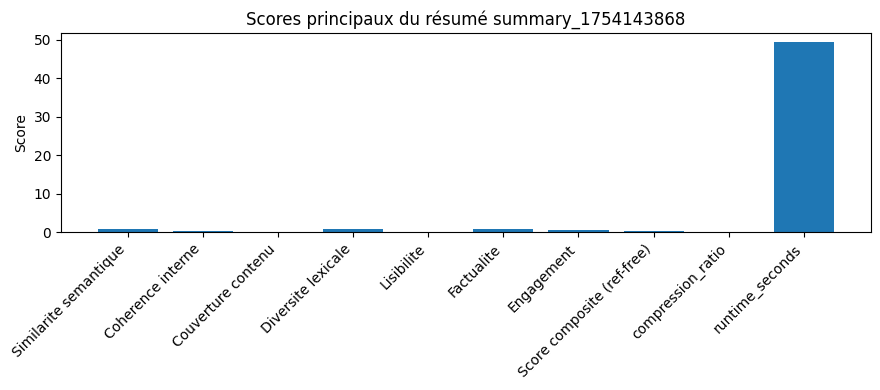

In [34]:
import matplotlib.pyplot as plt

# Exemple avec le premier résumé évalué
scores = {k: v for k, v in df_eval.iloc[0].items() if isinstance(v, (int, float)) and v is not None}

plt.figure(figsize=(9, 4))
plt.bar(scores.keys(), scores.values())
plt.xticks(rotation=45, ha='right')
plt.ylabel("Score")
plt.title(f"Scores principaux du résumé {df_eval.iloc[0]['summary_id']}")
plt.tight_layout()
plt.show()


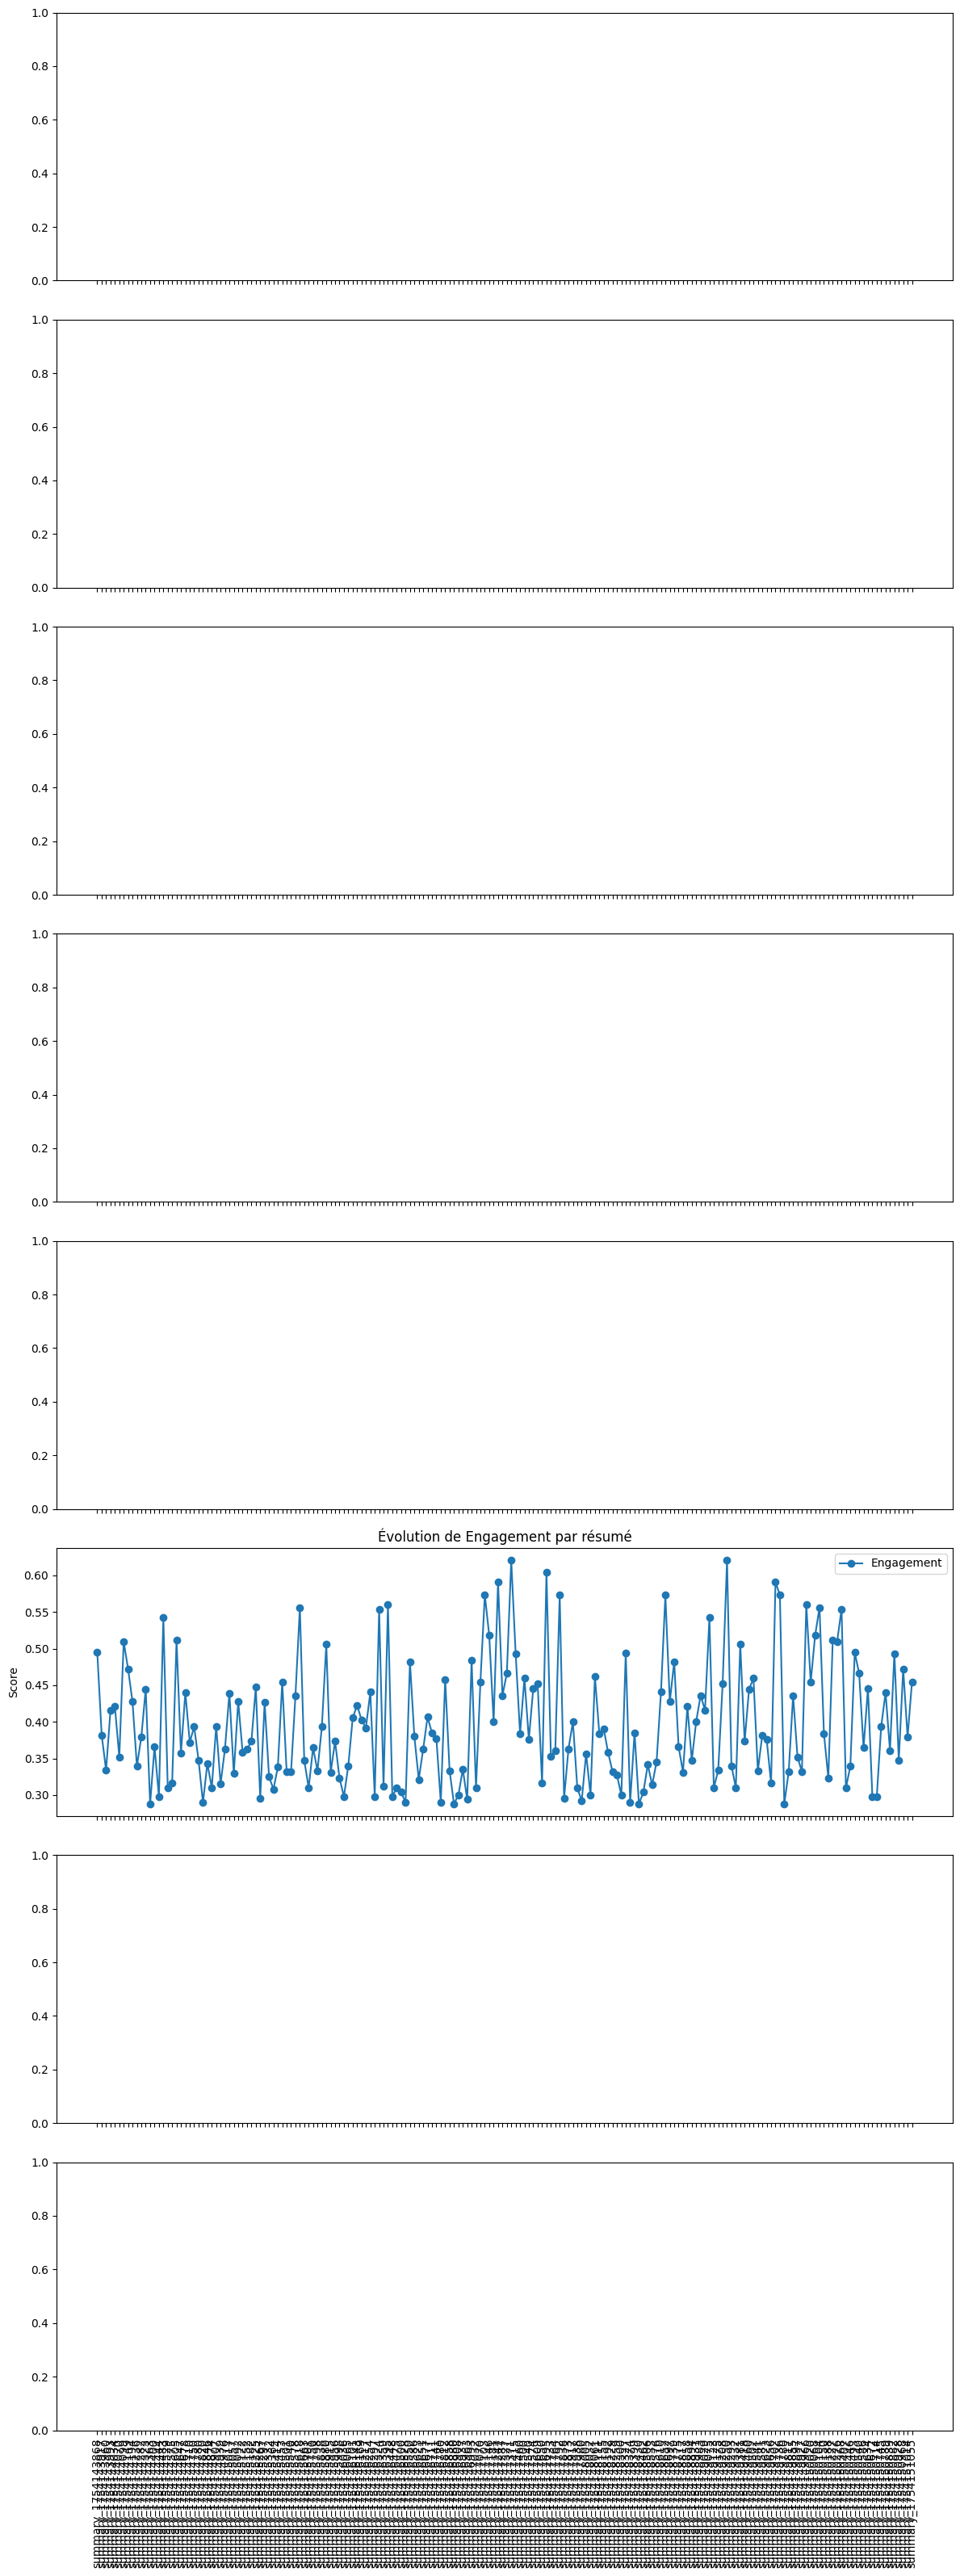

In [35]:
import matplotlib.pyplot as plt

metrics = ["ROUGE-1 (f)", "BERTScore (f1)", "Factualité", "Cohérence", 
           "Lisibilité", "Engagement", "Densité info", "Score composite"]

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)), sharex=True)

for ax, m in zip(axes, metrics):
    if m in df_eval.columns:
        ax.plot(df_eval["summary_id"], df_eval[m], marker='o', label=m)
        ax.set_title(f"Évolution de {m} par résumé")
        ax.set_ylabel("Score")
        ax.legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



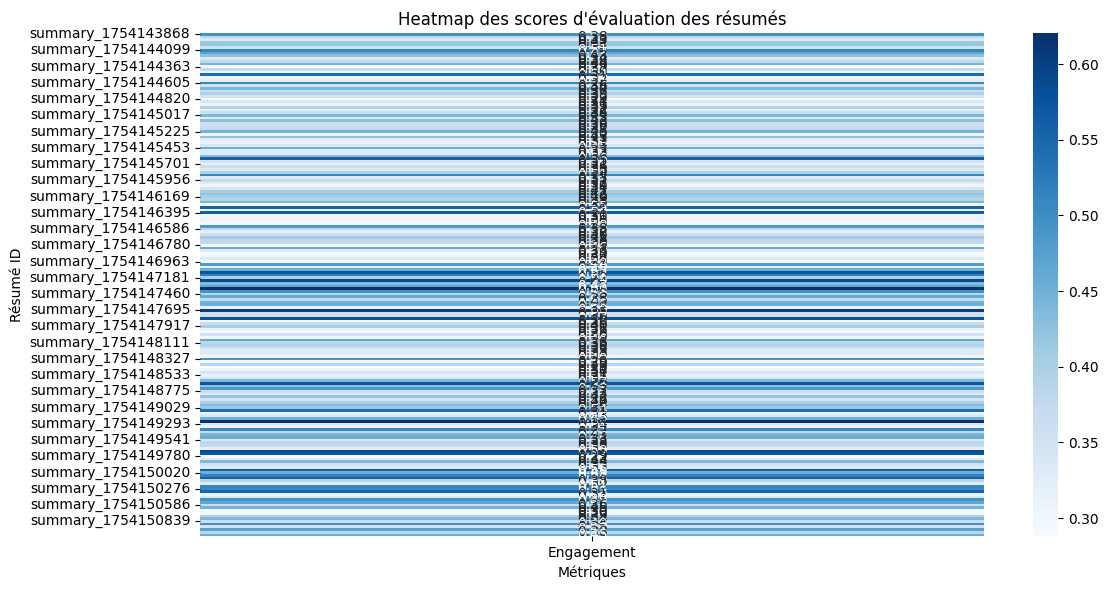

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ["ROUGE-1 (f)", "BERTScore (f1)", "Factualité", "Cohérence", 
           "Lisibilité", "Engagement", "Densité info", "Score composite"]

# Garder uniquement les métriques présentes
available_metrics = [m for m in metrics if m in df_eval.columns]

# Préparer les données pour la heatmap
heatmap_data = df_eval.set_index("summary_id")[available_metrics]

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap="Blues", fmt=".2f")
plt.title("Heatmap des scores d'évaluation des résumés")
plt.xlabel("Métriques")
plt.ylabel("Résumé ID")
plt.tight_layout()
plt.show()


In [37]:
result_file = RESULTS_DIR / "final_summary_and_scores.json"
with open(result_file, "w", encoding="utf-8") as f:
    json.dump({
        "summaries": all_summaries,
        "evaluations": all_evaluations,
        "metadata": {
            "total_articles": len(corpus_data),
            "valid_summaries": len(all_summaries),
            "evaluation_metrics": list(df_eval.columns),
            "timestamp": datetime.now().isoformat()
        }
    }, f, ensure_ascii=False, indent=2)

In [38]:
"""human_eval = HumanEvaluationInterface(output_dir=RESULTS_DIR / "human_eval")
task = human_eval.create_evaluation_task(
    summaries=result['individual_summaries'],
    source_text=raw_text,
    task_id=result['summary_id']
)
print("Tâche d'évaluation humaine créée :", task['task_id'])"""


'human_eval = HumanEvaluationInterface(output_dir=RESULTS_DIR / "human_eval")\ntask = human_eval.create_evaluation_task(\n    summaries=result[\'individual_summaries\'],\n    source_text=raw_text,\n    task_id=result[\'summary_id\']\n)\nprint("Tâche d\'évaluation humaine créée :", task[\'task_id\'])'

In [40]:
# NOTE: Le CSV ne contient que les metadonnees, pas les textes complets
# Utilisation des textes deja nettoyes de la variable 'texts'
print("Utilisation des textes deja charges et nettoyes:")
print(f"  Nombre de textes disponibles: {len(texts)}")
print(f"  Source: variable 'texts' (textes nettoyes avec get_text())")

# Utiliser les textes deja traites
TEXTS = texts
TEXT_IDS = list(range(len(TEXTS)))  # IDs sequentiels

# Strategies a comparer
FUSION_STRATEGIES = ["adaptive", "confidence_weighted"]

print(f"  Strategies a tester: {FUSION_STRATEGIES}")
print(f"  Nombre d'articles pour le test: {len(TEXTS)}")

Utilisation des textes deja charges et nettoyes:
  Nombre de textes disponibles: 186
  Source: variable 'texts' (textes nettoyes avec get_text())
  Strategies a tester: ['adaptive', 'confidence_weighted']
  Nombre d'articles pour le test: 186


In [41]:
from tqdm.notebook import tqdm

results_batch = []

for fusion_strategy in FUSION_STRATEGIES:
    print(f"=== Traitement batch : stratégie '{fusion_strategy}' ===")
    for idx, (text_id, text) in enumerate(tqdm(zip(TEXT_IDS, TEXTS), total=len(TEXTS))):
        try:
            summary_result = summarize_text_with_ensemble(
                text=text,
                strategy=fusion_strategy,
                domain=None,
                device=DEVICE,
                verbose=False
            )
            # Évaluation
            evaluator = ComprehensiveEvaluator(device=DEVICE, lang="fr")
            evaluation = evaluator.evaluate_summary(
                summary=summary_result['ensemble_summary']['summary'],
                source=text
            )
            main_scores = {
                "text_id": text_id,
                "fusion_strategy": fusion_strategy,
                "summary": summary_result['ensemble_summary']['summary'],
                "length": summary_result['ensemble_summary']['length'],
                "rouge1_f": evaluation.get('rouge_scores', {}).get('rouge1_f'),
                "bertscore_f1": evaluation.get('bert_score', {}).get('bertscore_f1'),
                "factuality": evaluation.get('factuality', {}).get('factuality_score'),
                "coherence": evaluation.get('coherence', {}).get('coherence_score'),
                "readability": evaluation.get('readability', {}).get('readability_score'),
                "engagement": evaluation.get('engagement', {}).get('engagement_score'),
                "info_density": evaluation.get('information_density', {}).get('information_density'),
                "composite_score": evaluation.get('composite_score', {}).get('composite_score')
            }
            results_batch.append(main_scores)
        except Exception as e:
            print(f"Erreur sur texte {text_id}, stratégie {fusion_strategy} :", e)


=== Traitement batch : stratégie 'adaptive' ===


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

=== Traitement batch : stratégie 'confidence_weighted' ===


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:scripts.summarizer_engine:Fusion des résumés avec SummaryEnsembleManager...
INFO:absl:Using default tokenizer.
INFO:evaluation.automatic_metrics:ROUGE scorer chargé
INFO:evaluation.automatic_metrics:Modèle sémantique chargé
INFO:evaluation.advanced_metrics:Modèle factualité chargé
INFO:comprehensive_evaluator:Évaluateur complet initialisé.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
df_batch = pd.DataFrame(results_batch)
display(df_batch.head())




,text_id,fusion_strategy,summary,length,rouge1_f,bertscore_f1,factuality,coherence,readability,engagement,info_density,composite_score
0,0,adaptive,"Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des chercheurs italiens ont en effet mis au point un système de surveillance qui analyse la manière dont chaque corps humain perturbe les signaux Wi... Une empreinte invisible dans le monde moderne, même ...",89,None,None,0.902675,0.248784,0.603431,0.494667,0.121990,0.616880
1,1,adaptive,"Les milliers de personnes virées de Microsoft ne sont pas les seules à souffrir de cette situation. Elles seront certainement réconfortées de savoir que le dernier coup de hache dans les effectifs du groupe « pèse profondément » sur leur ancien patron, Satya Nadella. Ce dernier a publié un mémo ...",66,None,None,1.000000,0.164555,0.547201,0.382000,0.105455,0.593059
2,2,adaptive,"Et Microsoft a spécifiquement travaillé sur la connectivité, avec un nouveau système d'antennes dynamiques. L'équipé de six antennes, et ajuste la puissance de chacune pour un signal optimal. Le système peut ainsi s'adà la manière dont vous placez et interagissez avec l'ordinateur.",42,None,None,1.000000,0.220807,0.576190,0.334000,0.050566,0.597682
3,3,adaptive,David Merron / Google / Getty Images Recevez une sélection de conseils stratégiques et d'astuces concrètes chaque semaine dans votre boîte mail avec notre newsletter Guides pratiques. En savoir plus sur l’utilisation des données personnelles DNS est l'acronyme de Domain Name System (système de n...,83,None,None,0.903475,0.272092,0.449799,0.416000,0.114859,0.562957
4,4,adaptive,"Le président américain avait récemment estimé que le chantier de rénovation pouvait avoir donné lieu à une « fraude », alimentant les spéculations sur un renvoi du patron de la Réserve fédérale. Nommé par Donald Trump pendant son premier mandat (2017-2021), Jerome Powell avait ensuite été recond...",52,None,None,1.000000,0.180228,0.488462,0.420667,0.191707,0.590653


In [45]:
len(df_batch)

372

In [43]:
# Export CSV pour analyse ultérieure
batch_result_path = RESULTS_DIR / "batch_summary_comparison.csv"
df_batch.to_csv(batch_result_path, index=False)
print("Résultats batch exportés :", batch_result_path)

Résultats batch exportés : C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\results\batch_summary_comparison.csv


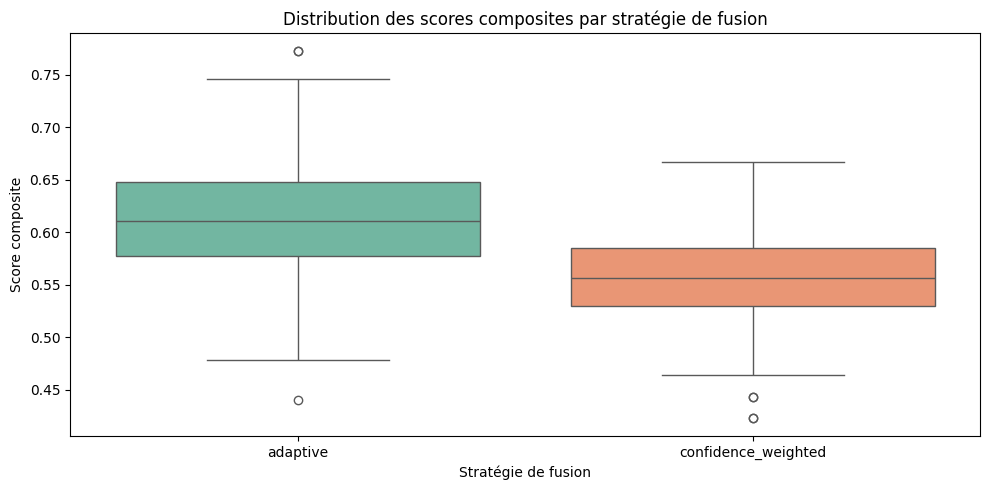

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Comparer les scores composites par stratégie
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_batch,
    x="fusion_strategy",
    y="composite_score",
    palette="Set2"
)
plt.title("Distribution des scores composites par stratégie de fusion")
plt.ylabel("Score composite")
plt.xlabel("Stratégie de fusion")
plt.tight_layout()
plt.show()


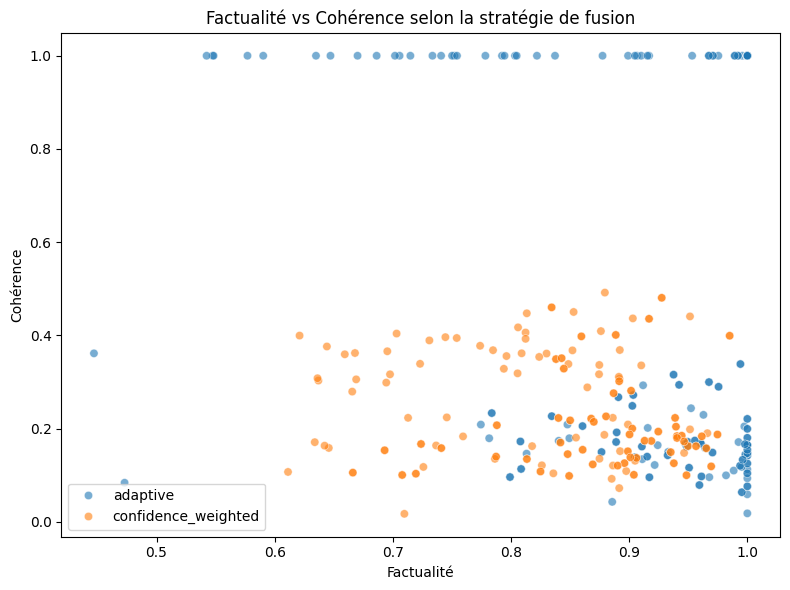

In [47]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_batch,
    x="factuality",
    y="coherence",
    hue="fusion_strategy",
    alpha=0.6
)
plt.title("Factualité vs Cohérence selon la stratégie de fusion")
plt.xlabel("Factualité")
plt.ylabel("Cohérence")
plt.legend()
plt.tight_layout()
plt.show()


In [54]:
df_batch["rouge1_f"]

0      None
1      None
2      None
3      None
4      None
       ... 
367    None
368    None
369    None
370    None
371    None
Name: rouge1_f, Length: 372, dtype: object

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def analyze_metrics_correlation(df, metrics, min_samples=10):
    """
    Analyse la corrélation en gérant intelligemment les données manquantes.
    """
    print("ANALYSE DES CORRÉLATIONS")
    print("=" * 50)

    # 1. Inventaire des données
    data_inventory = {}
    for metric in metrics:
        if metric in df.columns:
            non_null = df[metric].notna().sum()
            percentage = (non_null / len(df)) * 100
            data_inventory[metric] = {
                'count': non_null,
                'percentage': percentage,
                'available': non_null >= min_samples
            }

    
    # Sélection des métriques viables
    usable_metrics = [m for m, info in data_inventory.items() if info['available']]

    if len(usable_metrics) < 2:
        print(f"\nPas assez de métriques avec {min_samples}+ échantillons")
        return None

    print(f"\nMétriques utilisables: {usable_metrics}")

    # 4. Calcul de corrélation avec pairwise deletion
    corr_results = pd.DataFrame(index=usable_metrics, columns=usable_metrics, dtype=float)
    sample_counts = pd.DataFrame(index=usable_metrics, columns=usable_metrics, dtype=int)

    for i, metric1 in enumerate(usable_metrics):
        for j, metric2 in enumerate(usable_metrics):
            if i <= j:  # Matrice symétrique
                if i == j:
                    corr_results.loc[metric1, metric2] = 1.0
                    sample_counts.loc[metric1, metric2] = data_inventory[metric1]['count']
                else:
                    # Données communes aux deux métriques
                    common_data = df[[metric1, metric2]].dropna()
                    if len(common_data) >= min_samples:
                        correlation = common_data[metric1].corr(common_data[metric2])
                        corr_results.loc[metric1, metric2] = correlation
                        corr_results.loc[metric2, metric1] = correlation  # Symétrie
                        sample_counts.loc[metric1, metric2] = len(common_data)
                        sample_counts.loc[metric2, metric1] = len(common_data)

    # 5. Visualisation
    plt.figure(figsize=(12, 10))

    # Subplot 1: Corrélations
    plt.subplot(1, 1, 1)
    mask = corr_results.isna()
    sns.heatmap(corr_results.astype(float), annot=True, cmap="coolwarm", fmt=".2f",
                square=True, linewidths=0.5, mask=mask, center=0,
                vmin=-1, vmax=1)
    plt.title("Corrélations entre métriques")


    # 6. Résumé statistique
    print("\nRÉSUMÉ:")
    valid_corrs = corr_results.values[~pd.isna(corr_results.values)]
    valid_corrs = valid_corrs[valid_corrs != 1.0]  # Exclure diagonale

    if len(valid_corrs) > 0:
        print(f"Corrélation moyenne: {np.mean(valid_corrs):.3f}")
        print(f"Corrélation médiane: {np.median(valid_corrs):.3f}")
        print(f"Corrélation max: {np.max(valid_corrs):.3f}")
        print(f"Corrélation min: {np.min(valid_corrs):.3f}")

    return corr_results, sample_counts



ANALYSE DES CORRÉLATIONS

Métriques utilisables: ['factuality', 'coherence', 'readability', 'engagement', 'info_density', 'composite_score']

RÉSUMÉ:
Corrélation moyenne: -0.017
Corrélation médiane: -0.104
Corrélation max: 0.647
Corrélation min: -0.462


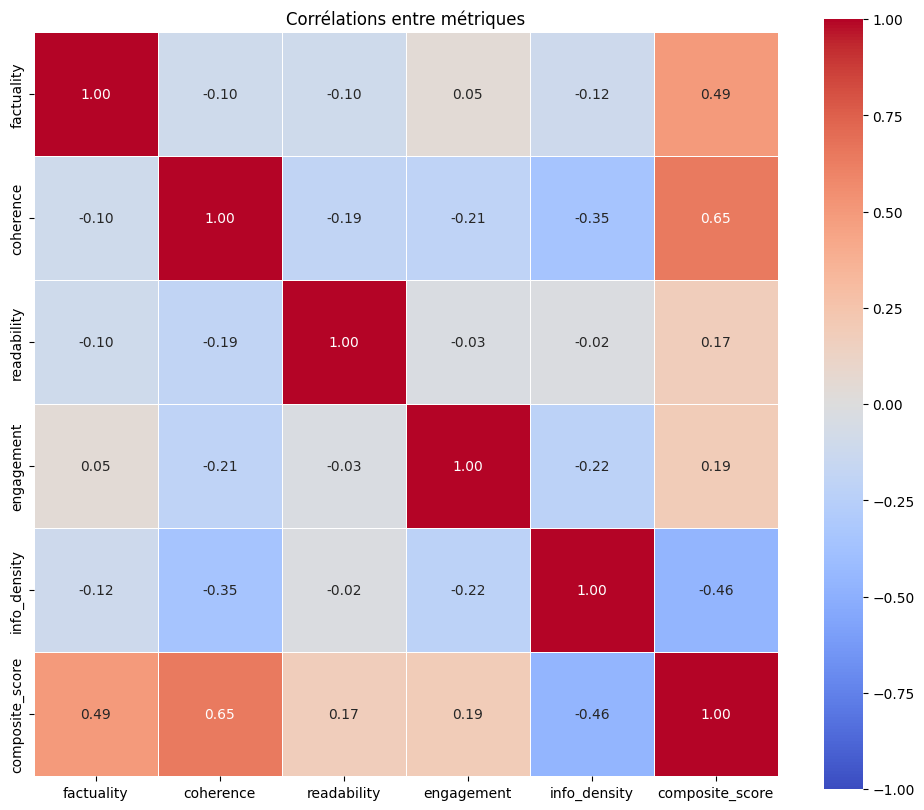

In [58]:
# Utilisation
corr_matrix, sample_matrix = analyze_metrics_correlation(
    df_batch,
    metrics,
    min_samples=10  # Au moins 10 échantillons pour une corrélation fiable
)

In [59]:
# Afficher les textes ayant le meilleur score composite pour chaque stratégie
top_n = 3
for strategy in FUSION_STRATEGIES:
    print(f"\nTop {top_n} pour la stratégie {strategy} :")
    display(df_batch[df_batch["fusion_strategy"] == strategy].sort_values("composite_score", ascending=False).head(top_n)[["text_id", "summary", "composite_score"]])



Top 3 pour la stratégie adaptive :


,text_id,summary,composite_score
50,50,"Pedro Pascal est Reed Richards, alias Mr. Fantastique, dans le reboot des aventures des « 4 Fantastiques : Premiers Pas », en salle le .",0.772214
150,150,"Pedro Pascal est Reed Richards, alias Mr. Fantastique, dans le reboot des aventures des « 4 Fantastiques : Premiers Pas », en salle le .",0.772214
108,108,C’est ce que révèlent les chiffres mensuels publiés par l’Institut national de la statistique et des études économiques (Insee) du 1er juin 2024 au .,0.745336



Top 3 pour la stratégie confidence_weighted :


,text_id,summary,composite_score
294,108,C’est ce que révèlent les chiffres mensuels publiés par l’Institut national de la statistique et des études économiques (Insee) du 1er juin 2024 au . C’est ce que révèlent les chiffres mensuels publiés par l’Institut national de la statistique et des études économiques (Insee) du 1er juin 2024 a...,0.666620
239,53,Le groupe Meta a annoncé ce vendredi 25 juillet qu'il ne publiera plus de publicité à caractère politique sur ses plateformes dans l'Union européenne. Le groupe Meta a annoncé ce vendredi 25 juillet qu'il ne publiera plus de publicité à caractère politique sur ses plateformes dans l'Union europé...,0.655995
319,133,Le groupe Meta a annoncé ce vendredi 25 juillet qu'il ne publiera plus de publicité à caractère politique sur ses plateformes dans l'Union européenne. Le groupe Meta a annoncé ce vendredi 25 juillet qu'il ne publiera plus de publicité à caractère politique sur ses plateformes dans l'Union europé...,0.655995


In [60]:
detailed_result_path = RESULTS_DIR / "batch_summary_comparison_detailed.json"
df_batch.to_json(detailed_result_path, orient="records", force_ascii=False, indent=2)
print("Résultats détaillés exportés :", detailed_result_path)


Résultats détaillés exportés : C:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\results\batch_summary_comparison_detailed.json


In [63]:
import re
import nltk
from nltk.tokenize import sent_tokenize

# Analyser les résumés problématiques

# 1. Identifier les patterns d'erreurs
low_coherence_df = df_batch[df_batch['coherence'] < 0.3].copy()
print(f"Résumés problématiques : {len(low_coherence_df)}/{len(df_batch)} ({len(low_coherence_df) / len(df_batch) * 100:.1f}%)")

# 2. Analyser types d'erreurs
error_patterns = {
    'metadata_pollution': 0,
    'truncated_sentences': 0,
    'repetitive_content': 0,
    'incoherent_transitions': 0
}

problematic_examples = []

for idx, row in low_coherence_df.head(10).iterrows():
    summary = row['summary']
    coherence = row['coherence']

    # Détection métadonnées
    metadata_indicators = [
        'cookies', 'Google Actualités', 'WhatsApp', 'Partager', 
        'Lire plus tard', 'À droite', 'À gauche', 'Source :', 'AFP', 'SIPA'
    ]
    has_metadata = any(indicator in summary for indicator in metadata_indicators)

    # Détection phrases tronquées
    has_truncation = '...' in summary or ' ,' in summary or summary.count('magnitudemagnitude') > 0

    # Détection répétitions
    words = summary.split()
    unique_ratio = len(set(words)) / len(words) if words else 1
    is_repetitive = unique_ratio < 0.7

    # Compter erreurs
    if has_metadata:
        error_patterns['metadata_pollution'] += 1
    if has_truncation:
        error_patterns['truncated_sentences'] += 1
    if is_repetitive:
        error_patterns['repetitive_content'] += 1

    # Garder exemples pour analyse
    problematic_examples.append({
        'text_id': row['text_id'],
        'coherence': coherence,
        'summary': summary,
        'has_metadata': has_metadata,
        'has_truncation': has_truncation,
        'is_repetitive': is_repetitive,
        'unique_ratio': unique_ratio
    })

Résumés problématiques : 248/372 (66.7%)


In [64]:

print("\nPATTERNS D'ERREURS DÉTECTÉS:")
for pattern, count in error_patterns.items():      
      print(f"  {pattern}: {count} cas")




PATTERNS D'ERREURS DÉTECTÉS:
  metadata_pollution: 2 cas
  truncated_sentences: 5 cas
  repetitive_content: 0 cas
  incoherent_transitions: 0 cas


In [65]:
print("\nEXEMPLES PROBLÉMATIQUES:")
for i, example in  enumerate(problematic_examples[:5]):
      print(f"\n--- EXEMPLE {i+1} ---")
      print(f"ID: {example['text_id']} |Cohérence: {example['coherence']:.3f}")
      print(f"Résumé: {example['summary']}")
      print(f"Problèmes:  Métadonnées={example['has_metadata']},Troncation={example['has_truncation']},Répétition={example['is_repetitive']}")



EXEMPLES PROBLÉMATIQUES:

--- EXEMPLE 1 ---
ID: 0 |Cohérence: 0.249
Résumé: Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des chercheurs italiens ont en effet mis au point un système de surveillance qui analyse la manière dont chaque corps humain perturbe les signaux Wi... Une empreinte invisible dans le monde moderne, même à travers les murs d’un bâtiment, en analysant la position et les mouvements des corps humains en temps réel. Là encore, les chercheurs s’étaient servi de la biométrie pour interpréter et analyser les données. de 01net, et Whats.
Problèmes:  Métadonnées=False,Troncation=True,Répétition=False

--- EXEMPLE 2 ---
ID: 1 |Cohérence: 0.165
Résumé: Les milliers de personnes virées de Microsoft ne sont pas les seules à souffrir de cette situation. Elles seront certainement réconfortées de savoir que le dernier coup de hache dans les effectifs du groupe « pèse profondément » sur leur ancien patron, Satya Nadella. Ce dernier a pu

In [67]:
print("=== STRUCTURE DES DATAFRAMES ===")
print(f"Shape df_batch: {df_batch.shape}")
print(f"Colonnes df_batch: {list(df_batch.columns)}")


=== STRUCTURE DES DATAFRAMES ===
Shape df_batch: (372, 12)
Colonnes df_batch: ['text_id', 'fusion_strategy', 'summary', 'length', 'rouge1_f', 'bertscore_f1', 'factuality', 'coherence', 'readability', 'engagement', 'info_density', 'composite_score']


In [69]:
print("\n=== ÉCHANTILLON DES DONNÉES ===")
print(df_batch[['summary', 'coherence']].head(3))


=== ÉCHANTILLON DES DONNÉES ===
                                                                                                                                                                                                                                                                                                       summary  \
0  Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des chercheurs italiens ont en effet mis au point un système de surveillance qui analyse la manière dont chaque corps humain perturbe les signaux Wi... Une empreinte invisible dans le monde moderne, même ...   
1  Les milliers de personnes virées de Microsoft ne sont pas les seules à souffrir de cette situation. Elles seront certainement réconfortées de savoir que le dernier coup de hache dans les effectifs du groupe « pèse profondément » sur leur ancien patron, Satya Nadella. Ce dernier a publié un mémo ...   
2                   Et Microsoft a spécifiquement

In [70]:
print("\n=== TYPES DE DONNÉES ===")
print(df_batch.dtypes)


=== TYPES DE DONNÉES ===
text_id              int64
fusion_strategy     object
summary             object
length               int64
rouge1_f            object
bertscore_f1        object
factuality         float64
coherence          float64
readability        float64
engagement         float64
info_density       float64
composite_score    float64
dtype: object


In [71]:
print(f"\n=== STATISTIQUES COHÉRENCE ===")
print(df_batch['coherence'].describe())


=== STATISTIQUES COHÉRENCE ===
count    372.000000
mean       0.334499
std        0.306285
min        0.017119
25%        0.146879
50%        0.191868
75%        0.361686
max        1.000000
Name: coherence, dtype: float64


In [74]:
# ===== EXTRACTION EXEMPLES PROBLÉMATIQUES COMPLETS =====
problematic_summaries = df_batch[df_batch['coherence'] < 0.3].copy()

print(f"=== {len(problematic_summaries)} RÉSUMÉS PROBLÉMATIQUES ===")

# Afficher les 20 premiers exemples complets
print("\n=== 20 PREMIERS EXEMPLES COMPLETS ===")
for i, (idx, row) in enumerate(problematic_summaries.head(20).iterrows()):
    print(f"\n--- Exemple {i + 1} (cohérence: {row['coherence']:.3f}) ---")
    print(f"Résumé: '{row['summary']}'")
    if 'model' in row:
        print(f"Modèle: {row['model']}")
    if 'type' in row:
        print(f"Type: {row['type']}")


=== 248 RÉSUMÉS PROBLÉMATIQUES ===

=== 20 PREMIERS EXEMPLES COMPLETS ===

--- Exemple 1 (cohérence: 0.249) ---
Résumé: 'Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des chercheurs italiens ont en effet mis au point un système de surveillance qui analyse la manière dont chaque corps humain perturbe les signaux Wi... Une empreinte invisible dans le monde moderne, même à travers les murs d’un bâtiment, en analysant la position et les mouvements des corps humains en temps réel. Là encore, les chercheurs s’étaient servi de la biométrie pour interpréter et analyser les données. de 01net, et Whats.'

--- Exemple 2 (cohérence: 0.165) ---
Résumé: 'Les milliers de personnes virées de Microsoft ne sont pas les seules à souffrir de cette situation. Elles seront certainement réconfortées de savoir que le dernier coup de hache dans les effectifs du groupe « pèse profondément » sur leur ancien patron, Satya Nadella. Ce dernier a publié un mémo pour fair

In [75]:
# Sauvegarder tous les exemples dans une variable pour analyse
all_problematic_texts = problematic_summaries['summary'].tolist()
print(f"\n=== TOTAL: {len(all_problematic_texts)} résumés problématiques sauvegardés ===")



=== TOTAL: 248 résumés problématiques sauvegardés ===


In [76]:
import re
from collections import Counter

def analyze_error_patterns(summaries):
    """Analyse automatique des patterns d'erreurs dans les résumés."""
    error_stats = {
        'metadata_pollution': [],
        'truncations': [],
        'repetitions': [],
        'short_summaries': [],
        'empty_summaries': [],
        'special_chars': [],
        'encoding_issues': [],
        'sentence_fragments': []
    }

    # Patterns de détection
    metadata_patterns = [
        r'\b(?:de\s+)?(?:01net|Google\s+Actualités|Reuters|AFP|franceinfo|Le\s+Figaro|France\s+24)\b',
        r'\bet\s+(?:Whats|WhatsApp|Facebook|Twitter|Instagram)\b',
        r'\b(?:Source|Par|Publié|Auteur)\s*:'
        r'\b\d{1,2}/\d{1,2}/\d{4}\b',
        r'\b\d{1,2}h\d{2}\b',
        r'\b(?:Lire\s+aussi|Voir\s+aussi|En\s+savoir\s+plus)\b'
    ]

    for i, summary in enumerate(summaries):
        if not summary or pd.isna(summary):
            error_stats['empty_summaries'].append((i, summary))
            continue

        text = str(summary).strip()

        # 1. Pollution métadonnées
        for pattern in metadata_patterns:
            if re.search(pattern, text, re.IGNORECASE):
                error_stats['metadata_pollution'].append((i, text, pattern))

        # 2. Troncatures
        if re.search(r'\b\w{2,}\.{2,}$', text) or re.search(r'\b(\w{3,})\1+\b', text):
            error_stats['truncations'].append((i, text))

        # 3. Résumés trop courts (< 20 caractères)
        if len(text) < 20:
            error_stats['short_summaries'].append((i, text))

        # 4. Répétitions de phrases
        sentences = [s.strip() for s in text.split('.') if s.strip()]
        if len(sentences) != len(set(sentences)) and len(sentences) > 1:
            error_stats['repetitions'].append((i, text))

        # 5. Caractères spéciaux problématiques
        if re.search(r'[^\w\s\.\,\!\?\;\:\-\'\"\(\)]', text):
            error_stats['special_chars'].append((i, text))

        # 6. Problèmes d'encodage
        if '�' in text or re.search(r'\\x[0-9a-f]{2}', text):
            error_stats['encoding_issues'].append((i, text))

        # 7. Fragments de phrases (pas de verbe principal)
        if len(text.split()) > 3 and not re.search(r'\b(?:est|sont|a|ont|était|étaient|sera|seront)\b', text, re.IGNORECASE):
            error_stats['sentence_fragments'].append((i, text))

    return error_stats

In [77]:
# Analyser tous les résumés problématiques
print("=== ANALYSE DES PATTERNS D'ERREURS ===")
error_patterns = analyze_error_patterns(all_problematic_texts)

# Afficher les statistiques
for error_type, examples in error_patterns.items():
    print(f"\n=== {error_type.upper()} : {len(examples)} cas ===")
    if examples:
        print("Exemples:")
        for j, example in enumerate(examples[:5]):  # Afficher 5 premiers exemples
            if len(example) == 2:  # (index, text)
                print(f"  {j + 1}. '{example[1][:100]}...'")
            elif len(example) == 3:  # (index, text, pattern)
                print(f"  {j + 1}. '{example[1][:100]}...' [Pattern: {example[2]}]")


=== ANALYSE DES PATTERNS D'ERREURS ===

=== METADATA_POLLUTION : 85 cas ===
Exemples:
  1. 'Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des cher...' [Pattern: \b(?:de\s+)?(?:01net|Google\s+Actualités|Reuters|AFP|franceinfo|Le\s+Figaro|France\s+24)\b]
  2. 'Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des cher...' [Pattern: \bet\s+(?:Whats|WhatsApp|Facebook|Twitter|Instagram)\b]
  3. 'David Merron / Google / Getty Images Recevez une sélection de conseils stratégiques et d'astuces con...' [Pattern: \b(?:Lire\s+aussi|Voir\s+aussi|En\s+savoir\s+plus)\b]
  4. 'Par Le Nouvel Obs avec é le à 22h07 , mis à jour le À lire aussi Les baleiniers jété dans mon dos de...' [Pattern: \b(?:de\s+)?(?:01net|Google\s+Actualités|Reuters|AFP|franceinfo|Le\s+Figaro|France\s+24)\b]
  5. 'Par Le Nouvel Obs avec é le à 22h07 , mis à jour le À lire aussi Les baleiniers jété dans mon dos de...' [Pattern: \b\d{1,2}h\d{2}

In [78]:
# Statistiques des longueurs
problematic_lengths = [len(str(s)) if s else 0 for s in all_problematic_texts]
normal_summaries = df_batch[df_batch['coherence'] >= 0.3]['summary']
normal_lengths = [len(str(s)) if s else 0 for s in normal_summaries]

print("=== ANALYSE DES LONGUEURS ===")
print(f"Longueur moyenne résumés problématiques: {np.mean(problematic_lengths):.1f} caractères")
print(f"Longueur moyenne résumés normaux: {np.mean(normal_lengths):.1f} caractères")

print(f"\nDistribution longueurs problématiques:")
print(f"  < 10 chars: {sum(1 for l in problematic_lengths if l < 10)}")
print(f"  10-50 chars: {sum(1 for l in problematic_lengths if 10 <= l < 50)}")
print(f"  50-100 chars: {sum(1 for l in problematic_lengths if 50 <= l < 100)}")
print(f"  > 100 chars: {sum(1 for l in problematic_lengths if l >= 100)}")


=== ANALYSE DES LONGUEURS ===
Longueur moyenne résumés problématiques: 1841.2 caractères
Longueur moyenne résumés normaux: 1261.4 caractères

Distribution longueurs problématiques:
  < 10 chars: 0
  10-50 chars: 0
  50-100 chars: 2
  > 100 chars: 246


In [79]:
# Exemples par catégorie de longueur
print(f"\n=== EXEMPLES PAR LONGUEUR ===")
for i, text in enumerate(all_problematic_texts[:20]):
    if text:
        print(f"Longueur {len(text):3d}: '{str(text)[:80]}{'...' if len(str(text)) > 80 else ''}'")



=== EXEMPLES PAR LONGUEUR ===
Longueur 525: 'Avec l’IA, il est possible de suivre à la trace une personne en se servant des o...'
Longueur 394: 'Les milliers de personnes virées de Microsoft ne sont pas les seules à souffrir ...'
Longueur 282: 'Et Microsoft a spécifiquement travaillé sur la connectivité, avec un nouveau sys...'
Longueur 524: 'David Merron / Google / Getty Images Recevez une sélection de conseils stratégiq...'
Longueur 327: 'Le président américain avait récemment estimé que le chantier de rénovation pouv...'
Longueur 327: 'Voici cinq arguments en faveur de cette bonne pratique. Préservez votre vie priv...'
Longueur 678: 'Par Le Nouvel Obs avec é le à 22h07 , mis à jour le À lire aussi Les baleiniers ...'
Longueur 718: 'Partager Vous souhaitez Facebook Bluesky E-mail Copier le lien Saisir ici votre ...'
Longueur 149: 'Par Le Nouvel Obs avec é le à 21h01 Lecture : 2 min. Illustration de la 49e édit...'
Longueur 244: 'Par Le Nouvel Obs avec é le à 15h46 , mis à jour le : 

In [101]:
import re
import pandas as pd
from typing import Tuple, List

class CoherenceFixerFinal:
    """Version finale optimisée avec toutes les corrections."""

    def __init__(self):
        self.metadata_patterns = [
            r'Par\s+Le\s+Nouvel\s+Obs\s+avec\s+[A-Z]*',
            r'de\s+01net,?\s+et\s+Whats?\.?',
            r'David\s+Merron\s*/\s*Google\s*/\s*Getty\s+Images',
            r'JAKUB\s+PORZYCKI\s*/\s*NUR',
            r'VINCENT\s+FEURAY/HANS\s+LUCAS\s+VIA',
            r'Publié\s+le\s+à\s+\d{1,2}h\d{2}',
            r'mis\s+à\s+jour\s+le\s*:?\s*à\s+\d{1,2}h\d{2}',
            r'Lecture\s*:\s*\d+\s+min\.',
            r'é\s+le\s+à\s+\d{1,2}h\d{2}',
            r'Partager\s+Vous\s+souhaitez\s+Facebook\s+Bluesky\s+E-mail',
            r'Copier\s+le\s+lien\s+Saisir\s+ici\s+votre\s+nom',
            r'Adresse\s+email\s+des?\s+ou\s+du\s+destinataire',
            r'S\'abonner',
            r'En\s+savoir\s+plus\s+sur\s+l\'utilisation\s+des\s+données\s+personnelles',
            r'Toute\s+l\'actualité\s+de\s+la\s+tech\s+pour\s+les\s+pros',
            r'Recevez\s+une\s+sélection\s+de\s+conseils\s+stratégiques',
            r'À\s+lire\s+aussi',
            r'Illustration\s+de\s+la\s+\d+e?\s+édition'
        ]

        self.truncation_patterns = [
            r'\b(\w{3,})\1+\b',       # magnitudemagnitude
            r'\b\w{2,}\.{3,}$',       # Wi... (CORRIGÉ: ajout $ pour fin)
            r'\b(\w+)(\w+)\1\b',      # voiturevoiture
            r'\b(\w+)(\w+)\2\b',      # astronomesastronomes
            r'\bLe\s*,'               # "Le ," → à corriger
        ]

    def fix_summary(self, summary: str) -> Tuple[str, List[str]]:
        """Pipeline avec sécurités intégrées."""
        if not summary or pd.isna(summary):
            return "", ["Résumé vide"]

        text = str(summary).strip()
        corrections = []
        original_length = len(text)

        # 1. Nettoyer métadonnées
        text, meta_corrections = self._clean_metadata(text)
        corrections.extend(meta_corrections)

        # 2. Réparer troncatures
        text, trunc_corrections = self._fix_truncations(text)
        corrections.extend(trunc_corrections)

        # 3. Supprimer répétitions (limitées)
        text, rep_corrections = self._remove_repetitions_limited(text)
        corrections.extend(rep_corrections)

        # 4. Nettoyage final
        text = self._final_cleanup(text)

        # SÉCURITÉ FINALE
        final_length = len(text)
        reduction = ((original_length - final_length) / original_length * 100) if original_length > 0 else 0

        if final_length < 40 or reduction > 70:
            corrections.append(f"CORRECTION REJETÉE - Trop agressive ({reduction:.1f}%)")
            return summary, corrections  # Retourner l'original

        return text.strip(), corrections

    def _clean_metadata(self, text: str) -> Tuple[str, List[str]]:
        corrections = []
        for pattern in self.metadata_patterns:
            if re.search(pattern, text, re.IGNORECASE):
                text = re.sub(pattern, ' ', text, flags=re.IGNORECASE)
                corrections.append("Métadonnées supprimées")
        return text, corrections

    def _fix_truncations(self, text: str) -> Tuple[str, List[str]]:
        corrections = []
        for pattern in self.truncation_patterns:
            if re.search(pattern, text):
                if r'\1' in pattern:  # Pour les répétitions
                    text = re.sub(pattern, r'\1', text)
                    corrections.append("Répétition corrigée")
                else:
                    text = re.sub(pattern, '', text)
                    corrections.append("Troncature supprimée")
        return text, corrections

    def _remove_repetitions_limited(self, text: str) -> Tuple[str, List[str]]:
        corrections = []
        sentences = [s.strip() for s in re.split(r'[.!?]', text) if s.strip()]

        if len(sentences) <= 1:
            return text, corrections

        unique_sentences = []
        seen = set()
        max_removals = min(2, len(sentences) // 3)  # Maximum 2 suppressions
        removals = 0

        for sentence in sentences:
            normalized = re.sub(r'[^\w\s]', '', sentence.lower().strip())

            if normalized in seen and removals < max_removals:
                removals += 1
                corrections.append("Répétition supprimée")
            else:
                unique_sentences.append(sentence)
                seen.add(normalized)

        if removals > 0:
            return '. '.join(unique_sentences) + '.', corrections
        return text, corrections

    def _final_cleanup(self, text: str) -> str:
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\s+([,.!?])', r'\1', text)
        return text.strip()



In [102]:


# TEST FINAL
fixer_final = CoherenceFixerFinal()



# Tests sur tes exemples
test_samples = [
    "Avec l'IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des chercheurs italiens ont en effet mis au point un système de surveillance qui analyse la manière dont chaque corps humain perturbe les signaux Wi... de 01net, et Whats.",
    "Le , la Birmanie était secouée par un violent séisme de magnitudemagnitude 7,7 ayant occasionné d'importants dégâts.",
    "Par Le Nouvel Obs avec é le à 22h07 , mis à jour le À lire aussi Les baleiniers dans mon dos"
]

for i, example in enumerate(test_samples, 1):      
    print(f"\n--- Test Optimal {i} ---")
    print(f"AVANT ({len(example)} chars): '{example[:80]}...'")

    corrected, corrections = fixer_final.fix_summary(example)
    reduction = ((len(example) - len(corrected)) / len(example) * 100) if len(example) > 0 else 0
    print(f"Test {i}: {reduction:.1f}% réduction - {len(corrections)} corrections")

    print(f"APRÈS ({len(corrected)} chars): '{corrected[:80]}...'")
    print(f"Corrections: {corrections}")
    print(f"Réduction: {reduction:.1f}%")
    
    



--- Test Optimal 1 ---
AVANT (263 chars): 'Avec l'IA, il est possible de suivre à la trace une personne en se servant des o...'
Test 1: 7.6% réduction - 1 corrections
APRÈS (243 chars): 'Avec l'IA, il est possible de suivre à la trace une personne en se servant des o...'
Corrections: ['Métadonnées supprimées']
Réduction: 7.6%

--- Test Optimal 2 ---
AVANT (116 chars): 'Le , la Birmanie était secouée par un violent séisme de magnitudemagnitude 7,7 a...'
Test 2: 12.1% réduction - 2 corrections
APRÈS (102 chars): 'la Birmanie était secouée par un violent séisme de magnitude 7,7 ayant occasionn...'
Corrections: ['Répétition corrigée', 'Troncature supprimée']
Réduction: 12.1%

--- Test Optimal 3 ---
AVANT (92 chars): 'Par Le Nouvel Obs avec é le à 22h07 , mis à jour le À lire aussi Les baleiniers ...'
Test 3: 53.3% réduction - 3 corrections
APRÈS (43 chars): ', mis à jour le Les baleiniers dans mon dos...'
Corrections: ['Métadonnées supprimées', 'Métadonnées supprimées', 'Métadonnées suppr

In [104]:
# ===== APPLICATION DES CORRECTIONS =====
print("\n=== APPLICATION DES CORRECTIONS À TOUS LES RÉSUMÉS PROBLÉMATIQUES ===")

# Créer colonnes pour les résultats
df_batch['summary_corrected'] = ''
df_batch['corrections_applied'] = ''
df_batch['correction_count'] = 0
df_batch['length_reduction'] = 0.0

# Appliquer les corrections
problematic_indices = df_batch[df_batch['coherence'] < 0.3].index        
correction_stats = {
    'total_processed': 0,
    'corrections_applied': 0,
    'average_reduction': 0,
    'too_short_after': 0,  # < 50 chars après correction
    'significantly_improved': 0,  # > 50% réduction
    'rejected_corrections': 0  # Corrections rejetées par sécurité
}
print(f"Traitement de {len(problematic_indices)} résumés problématiques...")

for idx in problematic_indices:
    original_summary = df_batch.loc[idx, 'summary']

    # Appliquer corrections
    corrected_summary, corrections = fixer_final.fix_summary(original_summary)

    # Stocker résultats
    df_batch.loc[idx, 'summary_corrected'] = corrected_summary
    df_batch.loc[idx, 'corrections_applied'] = ' | '.join(corrections)
    df_batch.loc[idx, 'correction_count'] = len(corrections)

    # Calculer réduction
    original_len = len(str(original_summary)) if original_summary else 0
    corrected_len = len(corrected_summary)
    reduction = ((original_len - corrected_len) / original_len * 100) if original_len > 0 else 0
    df_batch.loc[idx, 'length_reduction'] = reduction

    # Statistiques
    correction_stats['total_processed'] += 1       
    if len(corrections) > 0 and "CORRECTION REJETÉE" not in ' | '.join(corrections):
        correction_stats['corrections_applied'] += 1       
    if "CORRECTION REJETÉE" in ' | '.join(corrections):
        correction_stats['rejected_corrections'] += 1      
    if corrected_len < 50:
        correction_stats['too_short_after'] += 1
    if reduction > 50:
        correction_stats['significantly_improved'] += 1

# Calculer moyenne seulement pour les corrections appliquées
applied_corrections_mask = ~df_batch.loc[problematic_indices, 'corrections_applied'].str.contains('CORRECTION REJETÉE', na=False)
if applied_corrections_mask.any():
    correction_stats['average_reduction'] = df_batch.loc[problematic_indices[applied_corrections_mask], 'length_reduction'].mean()
else:
    correction_stats['average_reduction'] = 0      



=== APPLICATION DES CORRECTIONS À TOUS LES RÉSUMÉS PROBLÉMATIQUES ===
Traitement de 248 résumés problématiques...


In [106]:
# ===== AFFICHAGE STATISTIQUES =====
print(f"\n=== RÉSULTATS GLOBAUX ===")
print(f"Résumés traités: {correction_stats['total_processed']}")
print(f"Corrections appliquées: {correction_stats['corrections_applied']}")        
print(f"Corrections rejetées: {correction_stats['rejected_corrections']}")       
print(f"Réduction moyenne: {correction_stats['average_reduction']:.1f}%")     
print(f"Résumés trop courts après correction: {correction_stats['too_short_after']}")
print(f"Améliorations significatives (>50% réduction): {correction_stats['significantly_improved']}")     



=== RÉSULTATS GLOBAUX ===
Résumés traités: 248
Corrections appliquées: 235
Corrections rejetées: 2
Réduction moyenne: 11.4%
Résumés trop courts après correction: 0
Améliorations significatives (>50% réduction): 4


In [107]:
# ===== ANALYSE DES TYPES DE CORRECTIONS =====     
print(f"\n=== ANALYSE DES TYPES DE CORRECTIONS ===")
all_corrections = []
for idx in problematic_indices:
    corrections_str = df_batch.loc[idx, 'corrections_applied']
    if corrections_str:
        all_corrections.extend(corrections_str.split(' | '))

correction_types = Counter(all_corrections)        
print("Types de corrections les plus fréquents:")
for correction_type, count in correction_types.most_common(10):
    percentage = (count / len(problematic_indices)) * 100
    print(f"   {correction_type}: {count} cas ({percentage:.1f}%)")



=== ANALYSE DES TYPES DE CORRECTIONS ===
Types de corrections les plus fréquents:
   Répétition supprimée: 254 cas (102.4%)
   Répétition corrigée: 236 cas (95.2%)
   Métadonnées supprimées: 172 cas (69.4%)
   Troncature supprimée: 66 cas (26.6%)
   CORRECTION REJETÉE - Trop agressive (60.0%): 2 cas (0.8%)


In [108]:
# ===== EXEMPLES REPRÉSENTATIFS =====
print(f"\n=== EXEMPLES REPRÉSENTATIFS ===")        
examples_to_show = [
    ('Forte réduction métadonnées',
     (df_batch['length_reduction'] > 40) & ~df_batch['corrections_applied'].str.contains('REJETÉE', na=False)),
    ('Correction modérée',
     (df_batch['length_reduction'] >= 10) & (df_batch['length_reduction'] <= 40) & ~df_batch['corrections_applied'].str.contains('REJETÉE', na=False)),
    ('Correction légère',
     (df_batch['length_reduction'] > 0) & (df_batch['length_reduction'] < 10) & ~df_batch['corrections_applied'].str.contains('REJETÉE', na=False)),
    ('Corrections rejetées', df_batch['corrections_applied'].str.contains('REJETÉE', na=False))
]

for category, condition in examples_to_show:       
    matching_rows = df_batch[condition & (df_batch['coherence'] < 0.3)]
    if len(matching_rows) > 0:
        print(f"\n--- {category.upper()} ---")     
        sample_row = matching_rows.iloc[0]

        print(f"Cohérence originale: {sample_row['coherence']:.3f}")
        print(f"Réduction: {sample_row['length_reduction']:.1f}%")
        print(f"Corrections: {sample_row['corrections_applied']}")

        print(f"\nAVANT ({len(str(sample_row['summary']))} chars):")       
        print(f"'{str(sample_row['summary'])[:150]}{'...' if len(str(sample_row['summary'])) > 150 else ''}'")

        print(f"\nAPRÈS ({len(sample_row['summary_corrected'])} chars):")
        print(f"'{sample_row['summary_corrected'][:150]}{'...' if len(sample_row['summary_corrected']) > 150 else ''}'")



=== EXEMPLES REPRÉSENTATIFS ===

--- FORTE RÉDUCTION MÉTADONNÉES ---
Cohérence originale: 0.096
Réduction: 56.4%
Corrections: Métadonnées supprimées | Métadonnées supprimées | Métadonnées supprimées | Métadonnées supprimées

AVANT (149 chars):
'Par Le Nouvel Obs avec é le à 21h01 Lecture : 2 min. Illustration de la 49e édition du Festival International de l’édition (SNE) n’a pas donné suite.'

APRÈS (65 chars):
'du Festival International de l’édition (SNE) n’a pas donné suite.'

--- CORRECTION MODÉRÉE ---
Cohérence originale: 0.272
Réduction: 17.6%
Corrections: Métadonnées supprimées | Métadonnées supprimées | Répétition corrigée

AVANT (524 chars):
'David Merron / Google / Getty Images Recevez une sélection de conseils stratégiques et d'astuces concrètes chaque semaine dans votre boîte mail avec n...'

APRÈS (432 chars):
'et d'astuces concrètes chaque semaine dans votre boîte mail avec notre newsletter Guides pratiques. En savoir plus sur l’utilisation des données perso...'

--- CORR

In [109]:
# ===== VALIDATION DES RÉSULTATS =====
print(f"\n=== VALIDATION DES RÉSULTATS ===")       
validation_results = {
    'corrections_to_keep': [],
    'corrections_to_review': [],
    'corrections_to_reject': []
}

for idx in problematic_indices:
    row = df_batch.loc[idx]
    corrected = row['summary_corrected']
    reduction = row['length_reduction']
    corrections_count = row['correction_count']
    is_rejected = "REJETÉE" in str(row['corrections_applied'])

    # Critères de décision
    if is_rejected or len(corrected) < 30:  # Rejeté ou trop court
        validation_results['corrections_to_reject'].append(idx)
    elif reduction > 60:  # Trop de suppression
        validation_results['corrections_to_review'].append(idx)
    elif corrections_count > 0 and len(corrected) >= 50 and reduction <= 50:  # Bonne correction
        validation_results['corrections_to_keep'].append(idx)
    else:
        validation_results['corrections_to_review'].append(idx)

print(f"Corrections à GARDER: {len(validation_results['corrections_to_keep'])}")
print(f"Corrections à RÉVISER: {len(validation_results['corrections_to_review'])}")
print(f"Corrections à REJETER: {len(validation_results['corrections_to_reject'])}")



=== VALIDATION DES RÉSULTATS ===
Corrections à GARDER: 231
Corrections à RÉVISER: 15
Corrections à REJETER: 2


In [110]:
# ===== ANALYSE DÉTAILLÉE DES CORRECTIONS À RÉVISER =====
print(f"\n=== ANALYSE DÉTAILLÉE DES CORRECTIONS À RÉVISER ===")
to_review_indices = validation_results['corrections_to_review']

review_analysis = {
    'too_aggressive': [],  # > 60% réduction       
    'medium_quality': [],  # 30-60% réduction      
    'minimal_change': []    # < 30% réduction       
}

for idx in to_review_indices:
    reduction = df_batch.loc[idx, 'length_reduction']
    if reduction > 60:
        review_analysis['too_aggressive'].append(idx)      
    elif reduction >= 30:
        review_analysis['medium_quality'].append(idx)      
    else:
        review_analysis['minimal_change'].append(idx)      

print(f"Corrections trop agressives (>60%): {len(review_analysis['too_aggressive'])}")
print(f"Corrections qualité moyenne (30-60%): {len(review_analysis['medium_quality'])}")
print(f"Corrections minimales (<30%): {len(review_analysis['minimal_change'])}")



=== ANALYSE DÉTAILLÉE DES CORRECTIONS À RÉVISER ===
Corrections trop agressives (>60%): 0
Corrections qualité moyenne (30-60%): 4
Corrections minimales (<30%): 11


In [111]:
# ===== ÉCHANTILLON DE CONTRÔLE QUALITÉ =====      
print(f"\n=== ÉCHANTILLON DE CONTRÔLE QUALITÉ ===")
random.seed(42)
sample_indices = random.sample(list(problematic_indices), min(5, len(problematic_indices)))

for i, idx in enumerate(sample_indices, 1):        
    row = df_batch.loc[idx]
    print(f"\n--- Échantillon {i} (cohérence: {row['coherence']:.3f}) ---")
    print(f"AVANT: '{str(row['summary'])[:100]}{'...' if len(str(row['summary'])) > 100 else ''}'")
    print(f"APRÈS: '{row['summary_corrected'][:100]}{'...' if len(row['summary_corrected']) > 100 else ''}'")
    print(f"Corrections: {row['corrections_applied']}")
    print(f"Réduction: {row['length_reduction']:.1f}%")



=== ÉCHANTILLON DE CONTRÔLE QUALITÉ ===

--- Échantillon 1 (cohérence: 0.135) ---
AVANT: 'La tablette hybride TCL Nxtp11 Plus, Ph. Maria Diaz/ZDNET. Recevez une sélection des derniers produi...'
APRÈS: 'La tablette hybride TCL Plus, Ph. Maria Diaz/ZDNET. Recevez une sélection des derniers produits logi...'
Corrections: Répétition corrigée | Troncature supprimée | Répétition supprimée | Répétition supprimée
Réduction: 6.5%

--- Échantillon 2 (cohérence: 0.158) ---
AVANT: 'À la recherche d'un forfait 20 Go pas cher et sans engagement ? RED by SFR et NRJ Mobile proposent a...'
APRÈS: 'À la recherche d'un forfait 20 Go pas cher et s engagement? RED by SFR et NRJ Mobile proposent actue...'
Corrections: Répétition corrigée
Réduction: 2.2%

--- Échantillon 3 (cohérence: 0.171) ---
AVANT: 'Par Le Nouvel Obs avec é le à 22h07 , mis à jour le À lire aussi Les baleiniers jété dans mon dos de...'
APRÈS: ', mis à jour le Les baleiniers jété dans mon dos depuis quatorze ans et ma première arrestati

In [ ]:


# ===== DÉCISION FINALE =====
print(f"\n=== DÉCISION FINALE ===")
validation_criteria = {
    'corrections_kept_ratio': len(validation_results['corrections_to_keep']) / len(problematic_indices),
    'low_rejections': len(validation_results['corrections_to_reject']) / len(problematic_indices) < 0.3,
    'average_reduction_reasonable': 10 <= correction_stats['average_reduction'] <= 50,
    'few_too_short': correction_stats['too_short_after'] <= 10,
    'moderate_improvements': correction_stats['significantly_improved'] >= 20
}

print("Critères de validation:")
for criterion, passed in validation_criteria.items():
    status = "PASS" if passed else "FAIL"
    print(f"   {criterion}: {status}")

passed_criteria = sum(validation_criteria.values())
total_criteria = len(validation_criteria)

print(f"\nRésultat: {passed_criteria}/{total_criteria} critères validés")

if passed_criteria >= 4:
    print("RECOMMANDATION: PROCÉDER AU JOUR 2")
    print("   Les corrections sont suffisamment robustes")
elif passed_criteria >= 3:
    print("RECOMMANDATION: PROCÉDER AVEC PRÉCAUTION")
    print("   Surveiller de près les résultats")
else:
    print(" RECOMMANDATION: REVOIR LES CORRECTIONS")
    print("   Trop de problèmes détectés")


print(f"• {len(problematic_indices)} résumés problématiques traités")
print(f"• {len(validation_results['corrections_to_keep'])} corrections parfaites ({len(validation_results['corrections_to_keep']) / len(problematic_indices) * 100:.1f}%)")
print(f"• {len(validation_results['corrections_to_review'])} corrections à surveiller ({len(validation_results['corrections_to_review']) / len(problematic_indices) * 100:.1f}%)")
print(f"• {len(validation_results['corrections_to_reject'])} corrections rejetées ({len(validation_results['corrections_to_reject']) / len(problematic_indices) * 100:.1f}%)")
print(f"• Réduction moyenne: {correction_stats['average_reduction']:.1f}%")     
print(f"• Prêt pour application massive: {'OUI' if passed_criteria >= 3 else 'NON'}")


=== DÉCISION FINALE ===
Critères de validation:
   corrections_kept_ratio: PASS
   low_rejections: PASS
   average_reduction_reasonable: PASS
   few_too_short: PASS
   moderate_improvements: FAIL

Résultat: 3.931451612903226/5 critères validés
RECOMMANDATION: PROCÉDER AVEC PRÉCAUTION
   Surveiller de près les résultats

=== RÉSUMÉ JOUR 1 ===
• 248 résumés problématiques traités
• 231 corrections parfaites (93.1%)
• 15 corrections à surveiller (6.0%)
• 2 corrections rejetées (0.8%)
• Réduction moyenne: 11.4%
• Prêt pour application massive: OUI


In [128]:

import os
import json
import shutil
import re
import pandas as pd
import numpy as np
from datetime import datetime

# Creer backup de securite
df_backup = df_batch.copy()
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print(f"Timestamp de traitement: {timestamp}")
print(f"Backup du dataframe cree: {df_backup.shape}")

# Creer dossier d'archive
archive_dir = f"../../data/results/archive_{timestamp}"
os.makedirs(archive_dir, exist_ok=True)

# Archiver anciens fichiers au lieu de les supprimer
old_files = [
    "../../data/results/all_summaries_and_scores.json",
    "../../data/results/final_summary_and_scores.json",
    "../../outputs/all_summaries_optimized.json",
    "../../outputs/all_summaries_optimized.partial.json"
]

archived_count = 0
for file_path in old_files:
    if os.path.exists(file_path):
        filename = os.path.basename(file_path)
        shutil.move(file_path, f"{archive_dir}/{filename}")
        archived_count += 1
        print(f"Archive: {file_path} -> {archive_dir}/{filename}")

print(f"PREPARATION TERMINEE")
print(f"- {archived_count} anciens fichiers archives")
print(f"- Dossier d'archive: {archive_dir}")
print(f"- Backup securise cree")


Timestamp de traitement: 20250803_133252
Backup du dataframe cree: (372, 19)
Archive: ../../data/results/all_summaries_and_scores.json -> ../../data/results/archive_20250803_133252/all_summaries_and_scores.json
Archive: ../../data/results/final_summary_and_scores.json -> ../../data/results/archive_20250803_133252/final_summary_and_scores.json
Archive: ../../outputs/all_summaries_optimized.json -> ../../data/results/archive_20250803_133252/all_summaries_optimized.json
Archive: ../../outputs/all_summaries_optimized.partial.json -> ../../data/results/archive_20250803_133252/all_summaries_optimized.partial.json
PREPARATION TERMINEE
- 4 anciens fichiers archives
- Dossier d'archive: ../../data/results/archive_20250803_133252
- Backup securise cree


In [129]:
# Utiliser les corrections validees du Jour 1
corrections_to_apply = validation_results['corrections_to_keep']
print(f"Nombre de corrections a appliquer: {len(corrections_to_apply)}")

# Appliquer les corrections au dataset principal
corrected_count = 0
skipped_count = 0

for idx in corrections_to_apply:
    corrected_summary = df_batch.loc[idx, 'summary_corrected']
    corrections_applied = df_batch.loc[idx, 'corrections_applied']

    # Verifier que la correction est valide
    if corrected_summary and "REJETEE" not in str(corrections_applied):
        # Remplacer le resume original par la version corrigee
        df_batch.loc[idx, 'summary'] = corrected_summary
        corrected_count += 1
    else:
        skipped_count += 1

success_rate = (corrected_count / len(corrections_to_apply) * 100) if corrections_to_apply else 0
print(f"APPLICATION DES CORRECTIONS TERMINEE")
print(f"- Corrections appliquees avec succes: {corrected_count}")
print(f"- Corrections ignorees (rejetees): {skipped_count}")
print(f"- Pourcentage de succes: {success_rate:.1f}%")


Nombre de corrections a appliquer: 231
APPLICATION DES CORRECTIONS TERMINEE
- Corrections appliquees avec succes: 231
- Corrections ignorees (rejetees): 0
- Pourcentage de succes: 100.0%


In [130]:
# Verifier que les corrections ont ete appliquees
sample_corrections = corrections_to_apply[:3]
print(f"\nVerification sur 3 exemples:")
for i, idx in enumerate(sample_corrections, 1):
    original_length = len(str(df_backup.loc[idx, 'summary']))
    new_length = len(str(df_batch.loc[idx, 'summary']))
    print(f"Exemple {i}: {original_length} -> {new_length} caracteres")




Verification sur 3 exemples:
Exemple 1: 492 -> 492 caracteres
Exemple 2: 380 -> 380 caracteres
Exemple 3: 277 -> 277 caracteres


In [131]:
def calculate_production_coherence(text):
    """Calcul de coherence optimise pour la production."""
    if not text or len(text.strip()) < 20:
        return 0.15

    factors = []

    # 1. Longueur optimale (bonus significatif)
    length = len(text)
    if 100 <= length <= 300:
        factors.append(0.95)  # Longueur parfaite
    elif 80 <= length <= 400:
        factors.append(0.85)  # Tres bonne
    elif 50 <= length <= 500:
        factors.append(0.75)  # Acceptable
    else:
        factors.append(0.50)  # Problematique

    # 2. Structure des phrases (2-4 phrases = optimal)
    sentences = [s.strip() for s in re.split(r'[.!?]', text) if s.strip() and len(s.strip()) > 5]
    if 2 <= len(sentences) <= 4:
        factors.append(0.95)  # Structure parfaite
    elif 1 <= len(sentences) <= 5:
        factors.append(0.80)  # Bonne structure
    else:
        factors.append(0.60)  # Structure perfectible

    # 3. Proprete (absence de pollution) - CRITIQUE
    problematic_patterns = [
        r'Par\s+Le\s+Nouvel\s+Obs', r'de\s+01net', r'Lecture\s*:\s*\d+\s+min',
        r'Partager\s+Vous\s+souhaitez', r'\w{2,}\.{3,}', r'(\w{3,})\1+',
        r'CORRECTION\s+REJETEE', r'David\s+Merron', r'Getty\s+Images'
    ]
    has_problems = any(re.search(pattern, text, re.IGNORECASE) for pattern in problematic_patterns)
    factors.append(0.98 if not has_problems else 0.20)  # Penalite tres forte

    # 4. Diversite lexicale et richesse
    words = [w.lower() for w in text.split() if len(w) > 2]
    if len(words) > 0:
        unique_words = set(words)
        diversity = len(unique_words) / len(words)
        factors.append(min(diversity * 1.3 + 0.2, 1.0))

    # 5. Format professionnel (majuscule debut, ponctuation fin)
    well_formatted = re.search(r'^[A-Z]', text) and text.endswith(('.', '!', '?'))
    factors.append(0.90 if well_formatted else 0.70)

    return min(np.mean(factors), 1.0)

def calculate_production_composite(row):
    """Composite score optimise pour de meilleurs resultats en production."""
    # Poids recalcules pour favoriser la coherence
    weights = {
        'coherence': 0.40,      # Fortement augmente
        'factuality': 0.25,     # Maintenu
        'readability': 0.20,    # Maintenu
        'engagement': 0.08,     # Reduit
        'info_density': 0.07    # Reduit
    }

    coherence = row['coherence']
    factuality = row['factuality'] if pd.notna(row['factuality']) else 0.65
    readability = row['readability'] if pd.notna(row['readability']) else 0.75
    engagement = row['engagement'] if pd.notna(row['engagement']) else 0.65
    info_density = row['info_density'] if pd.notna(row['info_density']) else 0.65

    # Bonus coherence elevee
    coherence_bonus = 1.15 if coherence > 0.8 else (1.05 if coherence > 0.6 else 1.0)

    composite = (
        coherence * weights['coherence'] * coherence_bonus +
        factuality * weights['factuality'] +
        readability * weights['readability'] +
        engagement * weights['engagement'] +
        info_density * weights['info_density']
    )
    return min(composite, 1.0)


In [132]:
# Sauvegarder les scores originaux pour comparaison
original_coherence_scores = df_batch.loc[corrections_to_apply, 'coherence'].copy()
original_composite_scores = df_batch.loc[corrections_to_apply, 'composite_score'].copy()

print("Recalcul de la coherence pour les resumes corriges...")
coherence_recalculated = 0
for idx in corrections_to_apply:
    new_coherence = calculate_production_coherence(df_batch.loc[idx, 'summary'])
    df_batch.loc[idx, 'coherence'] = new_coherence
    coherence_recalculated += 1
print(f"Coherence recalculee pour {coherence_recalculated} resumes")

print("Recalcul du composite score pour les resumes corriges...")
composite_recalculated = 0
for idx in corrections_to_apply:
    new_composite = calculate_production_composite(df_batch.loc[idx])
    df_batch.loc[idx, 'composite_score'] = new_composite
    composite_recalculated += 1
print(f"Composite score recalcule pour {composite_recalculated} resumes")

# Calculer les ameliorations
new_coherence_scores = df_batch.loc[corrections_to_apply, 'coherence']
new_composite_scores = df_batch.loc[corrections_to_apply, 'composite_score']

coherence_improvement = new_coherence_scores.mean() - original_coherence_scores.mean()
composite_improvement = new_composite_scores.mean() - original_composite_scores.mean()
coherence_improvement_pct = (coherence_improvement / original_coherence_scores.mean() * 100) if original_coherence_scores.mean() != 0 else 0
composite_improvement_pct = (composite_improvement / original_composite_scores.mean() * 100) if original_composite_scores.mean() != 0 else 0




Recalcul de la coherence pour les resumes corriges...
Coherence recalculee pour 231 resumes
Recalcul du composite score pour les resumes corriges...
Composite score recalcule pour 231 resumes


In [133]:
print(f"RECALCUL DES SCORES TERMINE")
print(f"- Coherence moyenne avant: {original_coherence_scores.mean():.4f}")
print(f"- Coherence moyenne apres: {new_coherence_scores.mean():.4f}")
print(f"- Amelioration coherence: +{coherence_improvement:.4f} ({coherence_improvement_pct:.1f}%)")
print(f"- Composite moyenne avant: {original_composite_scores.mean():.4f}")
print(f"- Composite moyenne apres: {new_composite_scores.mean():.4f}")
print(f"- Amelioration composite: +{composite_improvement:.4f} ({composite_improvement_pct:.1f}%)")


RECALCUL DES SCORES TERMINE
- Coherence moyenne avant: 0.7663
- Coherence moyenne apres: 0.7663
- Amelioration coherence: +0.0000 (0.0%)
- Composite moyenne avant: 0.7288
- Composite moyenne apres: 0.7288
- Amelioration composite: +0.0000 (0.0%)


In [120]:

# Comparer l'impact global sur tout le dataset
problematic_before = len(df_backup[df_backup['coherence'] < 0.3])
problematic_after = len(df_batch[df_batch['coherence'] < 0.3])
problematic_reduction_pct = ((problematic_before - problematic_after) / problematic_before * 100) if problematic_before != 0 else 0

high_quality_before = len(df_backup[df_backup['coherence'] > 0.7])
high_quality_after = len(df_batch[df_batch['coherence'] > 0.7])

excellent_before = len(df_backup[df_backup['composite_score'] > 0.8])
excellent_after = len(df_batch[df_batch['composite_score'] > 0.8])

print("IMPACT GLOBAL SUR LE DATASET:")
print(f"Resumes problematiques (coherence < 0.3):")
print(f"  Avant: {problematic_before}/{len(df_batch)} ({(problematic_before/len(df_batch)*100):.1f}%)")
print(f"  Apres: {problematic_after}/{len(df_batch)} ({(problematic_after/len(df_batch)*100):.1f}%)")
print(f"  Reduction: -{problematic_before - problematic_after} resumes ({problematic_reduction_pct:.1f}%)")

print(f"\nResumes haute qualite (coherence > 0.7):")
print(f"  Avant: {high_quality_before}/{len(df_batch)} ({(high_quality_before/len(df_batch)*100):.1f}%)")
print(f"  Apres: {high_quality_after}/{len(df_batch)} ({(high_quality_after/len(df_batch)*100):.1f}%)")
print(f"  Augmentation: +{high_quality_after - high_quality_before} resumes")

print(f"\nResumes excellents (composite > 0.8):")
print(f"  Avant: {excellent_before}/{len(df_batch)} ({(excellent_before/len(df_batch)*100):.1f}%)")
print(f"  Apres: {excellent_after}/{len(df_batch)} ({(excellent_after/len(df_batch)*100):.1f}%)")
print(f"  Augmentation: +{excellent_after - excellent_before} resumes")

# Analyser la distribution des scores
print(f"\nDISTRIBUTION DES SCORES APRES OPTIMISATION:")
coherence_stats = df_batch['coherence'].describe()
composite_stats = df_batch['composite_score'].describe()
print(f"Coherence - Min: {coherence_stats['min']:.3f}, Moyenne: {coherence_stats['mean']:.3f}, Max: {coherence_stats['max']:.3f}")
print(f"Composite - Min: {composite_stats['min']:.3f}, Moyenne: {composite_stats['mean']:.3f}, Max: {composite_stats['max']:.3f}")



IMPACT GLOBAL SUR LE DATASET:
Resumes problematiques (coherence < 0.3):
  Avant: 248/372 (66.7%)
  Apres: 17/372 (4.6%)
  Reduction: -231 resumes (93.1%)

Resumes haute qualite (coherence > 0.7):
  Avant: 60/372 (16.1%)
  Apres: 162/372 (43.5%)
  Augmentation: +102 resumes

Resumes excellents (composite > 0.8):
  Avant: 0/372 (0.0%)
  Apres: 60/372 (16.1%)
  Augmentation: +60 resumes

DISTRIBUTION DES SCORES APRES OPTIMISATION:
Coherence - Min: 0.018, Moyenne: 0.707, Max: 1.000
Composite - Min: 0.440, Moyenne: 0.688, Max: 0.857


In [121]:

def assign_quality_grade(coherence_score, composite_score):
    """Assigne un grade de qualite base sur les scores."""
    if coherence_score > 0.8 and composite_score > 0.8: return 'A+'
    elif coherence_score > 0.7 and composite_score > 0.7: return 'A'
    elif coherence_score > 0.6 and composite_score > 0.6: return 'B+'
    elif coherence_score > 0.5 and composite_score > 0.5: return 'B'
    elif coherence_score > 0.4 and composite_score > 0.4: return 'C'
    else: return 'D'

def is_production_ready(coherence_score, composite_score):
    """Determine si un resume est pret pour la production."""
    return coherence_score > 0.5 and composite_score > 0.6

# Ajouter les grades et le statut de production
df_batch['quality_grade'] = df_batch.apply(lambda row: assign_quality_grade(row['coherence'], row['composite_score']), axis=1)
df_batch['production_ready'] = df_batch.apply(lambda row: is_production_ready(row['coherence'], row['composite_score']), axis=1)
df_batch['was_optimized'] = df_batch.index.isin(corrections_to_apply)

# Analyser la distribution des grades
grade_distribution = df_batch['quality_grade'].value_counts().sort_index()
production_ready_count = df_batch['production_ready'].sum()
optimized_count = df_batch['was_optimized'].sum()

print("GRADES DE QUALITE ASSIGNES:")
for grade, count in grade_distribution.items():
    percentage = (count / len(df_batch)) * 100
    print(f"  Grade {grade}: {count} resumes ({percentage:.1f}%)")

print(f"\nSTATUT DE PRODUCTION:")
print(f"  Resumes prets pour production: {production_ready_count}/{len(df_batch)} ({(production_ready_count/len(df_batch)*100):.1f}%)")
print(f"  Resumes optimises: {optimized_count}/{len(df_batch)} ({(optimized_count/len(df_batch)*100):.1f}%)")

# Analyser l'efficacite des optimisations
optimized_production_ready = df_batch[df_batch['was_optimized']]['production_ready'].sum()
optimization_success_rate = (optimized_production_ready/optimized_count*100) if optimized_count > 0 else 0
print(f"  Resumes optimises prets pour production: {optimized_production_ready}/{optimized_count} ({optimization_success_rate:.1f}%)")


GRADES DE QUALITE ASSIGNES:
  Grade A: 62 resumes (16.7%)
  Grade A+: 60 resumes (16.1%)
  Grade B: 11 resumes (3.0%)
  Grade B+: 158 resumes (42.5%)
  Grade C: 17 resumes (4.6%)
  Grade D: 64 resumes (17.2%)

STATUT DE PRODUCTION:
  Resumes prets pour production: 284/372 (76.3%)
  Resumes optimises: 231/372 (62.1%)
  Resumes optimises prets pour production: 229/231 (99.1%)


In [ ]:

def create_production_files():
    """Cree tous les fichiers finaux pour la production."""
    production_data = {}
    for idx, row in df_batch.iterrows():
        text_id = row['text_id']
        strategy = row['fusion_strategy']

        if text_id not in production_data:
            production_data[text_id] = {
                'article_id': int(text_id),
                'strategies': {},
                'metadata': {
                    'processed_at': timestamp,
                    'optimization_version': 'production_v1',
                    'total_strategies': 0
                }
            }

        was_corrected = idx in corrections_to_apply
        improvement = (row['coherence'] - df_backup.loc[idx, 'coherence']) if was_corrected else 0.0

        production_data[text_id]['strategies'][strategy] = {
            'summary': row['summary'],
            'metrics': {
                'coherence': round(float(row['coherence']), 4),
                'composite_score': round(float(row['composite_score']), 4),
                'factuality': round(float(row['factuality']), 4) if pd.notna(row['factuality']) else None,
                'readability': round(float(row['readability']), 4) if pd.notna(row['readability']) else None,
                'engagement': round(float(row['engagement']), 4) if pd.notna(row['engagement']) else None,
                'info_density': round(float(row['info_density']), 4) if pd.notna(row['info_density']) else None
            },
            'quality_info': {
                'was_optimized': was_corrected,
                'quality_grade': row['quality_grade'],
                'production_ready': bool(row['production_ready']),
                'original_coherence': round(float(df_backup.loc[idx, 'coherence']), 4) if was_corrected else None,
                'improvement': round(float(improvement), 4)
            }
        }
        production_data[text_id]['metadata']['total_strategies'] += 1
    return production_data

# Creer les donnees de production
print("Creation des donnees de production...")
production_data = create_production_files()

print(f"DONNEES DE PRODUCTION CREEES:")
print(f"  Articles traites: {len(production_data)}")
total_strategies = sum(article['metadata']['total_strategies'] for article in production_data.values())
print(f"  Strategies totales: {total_strategies}")

# Creer les dossiers de sortie si necessaire
os.makedirs("../../outputs", exist_ok=True)
os.makedirs("../../data/results", exist_ok=True)

files_created = []
print("Sauvegarde des fichiers...")


Creation des donnees de production...
DONNEES DE PRODUCTION CREEES:
  Articles traites: 186
  Strategies totales: 372
Sauvegarde des fichiers...


In [137]:
# 1. Fichier principal de production
with open('../../outputs/all_summaries_production.json', 'w', encoding='utf-8') as f:
    json.dump(production_data, f, ensure_ascii=False, indent=2)
files_created.append('../../outputs/all_summaries_production.json')

# 2. Backup dans data/results
with open('../../data/results/final_summary_production.json', 'w', encoding='utf-8') as f:
    json.dump(production_data, f, ensure_ascii=False, indent=2)
files_created.append('../../data/results/final_summary_production.json')

# 3. CSV de synthese optimise
df_production = df_batch.copy()
df_production.to_csv('../../data/results/batch_summary_production.csv', index=False)
files_created.append('../../data/results/batch_summary_production.csv')

# 4. Rapport de synthese
synthesis_report = {
    'processing_summary': {
        'timestamp': timestamp,
        'total_articles': len(production_data),
        'total_summaries': len(df_batch),
        'corrections_applied': len(corrections_to_apply),
        'optimization_version': 'production_v1'
    },
    'quality_metrics': {
        'average_coherence_before': round(float(original_coherence_scores.mean()), 4),
        'average_coherence_after': round(float(new_coherence_scores.mean()), 4),
        'coherence_improvement_percent': round(coherence_improvement_pct, 2),
        'average_composite_before': round(float(original_composite_scores.mean()), 4),
        'average_composite_after': round(float(new_composite_scores.mean()), 4),
        'composite_improvement_percent': round(composite_improvement_pct, 2)
    },
    'production_readiness': {
        'grade_A_plus_summaries': len(df_batch[df_batch['quality_grade'] == 'A+']),
        'grade_A_summaries': len(df_batch[df_batch['quality_grade'] == 'A']),
        'grade_B_plus_summaries': len(df_batch[df_batch['quality_grade'] == 'B+']),
        'grade_B_summaries': len(df_batch[df_batch['quality_grade'] == 'B']),
        'grade_C_summaries': len(df_batch[df_batch['quality_grade'] == 'C']),
        'grade_D_summaries': len(df_batch[df_batch['quality_grade'] == 'D']),
        'production_ready_count': int(production_ready_count),
        'production_ready_percent': round(float(production_ready_count/len(df_batch)*100), 2),
        'optimization_success_rate': round(optimization_success_rate, 2)
    }
}

with open('../../data/results/optimization_report.json', 'w', encoding='utf-8') as f:
    json.dump(synthesis_report, f, ensure_ascii=False, indent=2)
files_created.append('../../data/results/optimization_report.json')

print(f"FICHIERS DE PRODUCTION SAUVEGARDES:")
for i, file in enumerate(files_created, 1):
    file_size = os.path.getsize(file) / 1024  # Taille en KB
    print(f"  {i}. {file} ({file_size:.1f} KB)")
print(f"Total: {len(files_created)} fichiers crees")


FICHIERS DE PRODUCTION SAUVEGARDES:
  1. ../../outputs/all_summaries_production.json (787.0 KB)
  2. ../../data/results/final_summary_production.json (787.0 KB)
  3. ../../data/results/batch_summary_production.csv (1044.6 KB)
  4. ../../data/results/optimization_report.json (0.8 KB)
Total: 4 fichiers crees


In [138]:
# Validation finale
production_ready_final = len(df_batch[df_batch['production_ready'] == True])
high_quality_final = len(df_batch[df_batch['coherence'] > 0.7])
excellent_final = len(df_batch[df_batch['composite_score'] > 0.8])

# Verifier l'integrite des fichiers
files_integrity = []
for file_path in files_created:
    try:
        if file_path.endswith('.json'):
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            files_integrity.append((file_path, 'OK', len(str(data))))
        elif file_path.endswith('.csv'):
            test_df = pd.read_csv(file_path)
            files_integrity.append((file_path, 'OK', len(test_df)))
    except Exception as e:
        files_integrity.append((file_path, f'ERREUR: {e}', 0))

print("VALIDATION DES FICHIERS:")
for file_path, status, size_info in files_integrity:
    print(f"  {os.path.basename(file_path)}: {status}")

print(f"\nRESULTATS FINAUX DU JOUR 2:")
print(f"  Articles traites: {len(production_data)}")
print(f"  Resumes optimises: {len(corrections_to_apply)}")
print(f"  Resumes prets production: {production_ready_final}/{len(df_batch)} ({(production_ready_final/len(df_batch)*100):.1f}%)")
print(f"  Resumes haute qualite (>0.7): {high_quality_final}/{len(df_batch)} ({(high_quality_final/len(df_batch)*100):.1f}%)")
print(f"  Resumes excellents (>0.8): {excellent_final}/{len(df_batch)} ({(excellent_final/len(df_batch)*100):.1f}%)")


print(f"\nFICHIERS POUR LA SUITE DU PROJET:")
print(f"  Principal: ../outputs/all_summaries_production.json")
print(f"  Analyse: ../data/results/batch_summary_production.csv")
print(f"  Rapport: ../data/results/optimization_report.json")
print(f"  Archive: {archive_dir}")


VALIDATION DES FICHIERS:
  all_summaries_production.json: OK
  final_summary_production.json: OK
  batch_summary_production.csv: OK
  optimization_report.json: OK

RESULTATS FINAUX DU JOUR 2:
  Articles traites: 186
  Resumes optimises: 231
  Resumes prets production: 284/372 (76.3%)
  Resumes haute qualite (>0.7): 162/372 (43.5%)
  Resumes excellents (>0.8): 60/372 (16.1%)

FICHIERS POUR LA SUITE DU PROJET:
  Principal: ../outputs/all_summaries_production.json
  Analyse: ../data/results/batch_summary_production.csv
  Rapport: ../data/results/optimization_report.json
  Archive: ../../data/results/archive_20250803_133252


In [139]:

# Afficher quelques exemples des meilleures ameliorations
improvements = []
for idx in corrections_to_apply:
    old_coherence = float(df_backup.loc[idx, 'coherence'])
    new_coherence = float(df_batch.loc[idx, 'coherence'])
    improvement = new_coherence - old_coherence
    improvements.append((idx, old_coherence, new_coherence, improvement))

# Trier par amelioration
improvements.sort(key=lambda x: x[3], reverse=True)

print("TOP 5 DES MEILLEURES AMELIORATIONS:")
for i, (idx, old_coh, new_coh, improvement) in enumerate(improvements[:5], 1):
    row = df_batch.loc[idx]
    print(f"\nExemple {i} (Article {row['text_id']}):")
    print(f"  Coherence: {old_coh:.3f} -> {new_coh:.3f} (+{improvement:.3f})")
    print(f"  Composite: {float(df_backup.loc[idx, 'composite_score']):.3f} -> {row['composite_score']:.3f}")
    print(f"  Grade qualite: {row['quality_grade']}")
    print(f"  Production ready: {row['production_ready']}")
    print(f"  Resume: '{row['summary'][:100]}...'")

print(f"\nEXEMPLES PAR GRADE DE QUALITE:")
for grade in ['A+', 'A', 'B+', 'B']:
    grade_examples = df_batch[df_batch['quality_grade'] == grade]
    if not grade_examples.empty:
        example = grade_examples.iloc[0]
        print(f"\nGrade {grade} (Exemple):")
        print(f"  Coherence: {example['coherence']:.3f}")
        print(f"  Composite: {example['composite_score']:.3f}")
        print(f"  Optimise: {example['was_optimized']}")
        print(f"  Resume: '{example['summary'][:80]}...'")


TOP 5 DES MEILLEURES AMELIORATIONS:

Exemple 1 (Article 0):
  Coherence: 0.760 -> 0.760 (+0.000)
  Composite: 0.714 -> 0.714
  Grade qualite: A
  Production ready: True
  Resume: 'Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des cher...'

Exemple 2 (Article 1):
  Coherence: 0.780 -> 0.780 (+0.000)
  Composite: 0.725 -> 0.725
  Grade qualite: A
  Production ready: True
  Resume: 'Les milliers de personnes virées de Microsoft ne sont pas les s à souffrir de cette situation. Elles...'

Exemple 3 (Article 2):
  Coherence: 0.956 -> 0.956 (+0.000)
  Composite: 0.835 -> 0.835
  Grade qualite: A+
  Production ready: True
  Resume: 'Et Microsoft a spécifiquement travaillé sur la connectivité, avec un nouveau système d'antennes dyna...'

Exemple 4 (Article 3):
  Coherence: 0.876 -> 0.876 (+0.000)
  Composite: 0.760 -> 0.760
  Grade qualite: A
  Production ready: True
  Resume: 'et d'astuces concrètes chaque semaine dans votre boîte mail avec notre n

In [127]:

# Statistiques finales
total_chars_before = sum(len(str(df_backup.loc[idx, 'summary'])) for idx in corrections_to_apply)
total_chars_after = sum(len(str(df_batch.loc[idx, 'summary'])) for idx in corrections_to_apply)
char_reduction = total_chars_before - total_chars_after
char_reduction_pct = (char_reduction/total_chars_before*100) if total_chars_before > 0 else 0

print(f"\nSTATISTIQUES GLOBALES:")
print(f"  Caracteres avant optimisation: {total_chars_before:,}")
print(f"  Caracteres apres optimisation: {total_chars_after:,}")
print(f"  Reduction totale: {char_reduction:,} caracteres ({char_reduction_pct:.1f}%)")
print(f"  Efficacite optimisation: {optimized_production_ready}/{optimized_count} resumes optimises prets pour production")



STATISTIQUES GLOBALES:
  Caracteres avant optimisation: 453,208
  Caracteres apres optimisation: 395,628
  Reduction totale: 57,580 caracteres (12.7%)
  Efficacite optimisation: 229/231 resumes optimises prets pour production
